# Capstone Project

### Import required libraries

In [1]:
import numpy as np
#in case we need to repeat experiment
np.random.seed(255)

import pandas as pd
pd.options.display.max_rows = 25

import matplotlib.pyplot as plt
plt.style.use('classic')


import seaborn as sns
sns.set()

%matplotlib inline
%precision 3
debug = False

### Read data file

In [2]:
#df = pd.read_csv('NCDB_2016.csv', engine = 'python')
df = pd.read_csv('NCDB_1999_to_2016.csv', engine = 'python')

In [3]:
print(df.shape)

(6486831, 23)


In [4]:
print(df.head(2))

   C_YEAR C_MNTH C_WDAY C_HOUR  C_SEV C_VEHS C_CONF C_RCFG C_WTHR C_RSUR  \
0    1999     01      1     20      2     02     34     UU      1      5   
1    1999     01      1     20      2     02     34     UU      1      5   

   ...   V_TYPE V_YEAR P_ID P_SEX P_AGE P_PSN P_ISEV P_SAFE P_USER C_CASE  
0  ...       06   1990   01     M    41    11      1     UU      1    752  
1  ...       01   1987   01     M    19    11      1     UU      1    752  

[2 rows x 23 columns]


In [5]:
print(df.loc[0:4])

   C_YEAR C_MNTH C_WDAY C_HOUR  C_SEV C_VEHS C_CONF C_RCFG C_WTHR C_RSUR  \
0    1999     01      1     20      2     02     34     UU      1      5   
1    1999     01      1     20      2     02     34     UU      1      5   
2    1999     01      1     20      2     02     34     UU      1      5   
3    1999     01      1     08      2     01     01     UU      5      3   
4    1999     01      1     08      2     01     01     UU      5      3   

   ...   V_TYPE V_YEAR P_ID P_SEX P_AGE P_PSN P_ISEV P_SAFE P_USER C_CASE  
0  ...       06   1990   01     M    41    11      1     UU      1    752  
1  ...       01   1987   01     M    19    11      1     UU      1    752  
2  ...       01   1987   02     F    20    13      2     02      2    752  
3  ...       01   1986   01     M    46    11      1     UU      1    753  
4  ...       NN   NNNN   01     M    05    99      2     UU      3    753  

[5 rows x 23 columns]


In [6]:
df.dtypes

C_YEAR     int64
C_MNTH    object
C_WDAY    object
C_HOUR    object
C_SEV      int64
C_VEHS    object
C_CONF    object
C_RCFG    object
C_WTHR    object
C_RSUR    object
C_RALN    object
C_TRAF    object
V_ID      object
V_TYPE    object
V_YEAR    object
P_ID      object
P_SEX     object
P_AGE     object
P_PSN     object
P_ISEV    object
P_SAFE    object
P_USER    object
C_CASE     int64
dtype: object

In [7]:
#Move the dependent variable to the outside and drop C_CASE column
P_ISEV = df['P_ISEV']
P_ISEV
df.drop(columns = ['P_ISEV', 'C_SEV', 'C_CASE'], inplace = True)
df['P_ISEV'] = P_ISEV
df


,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_SAFE,P_USER,P_ISEV
0,1999,01,1,20,02,34,UU,1,5,3,...,01,06,1990,01,M,41,11,UU,1,1
1,1999,01,1,20,02,34,UU,1,5,3,...,02,01,1987,01,M,19,11,UU,1,1
2,1999,01,1,20,02,34,UU,1,5,3,...,02,01,1987,02,F,20,13,02,2,2
3,1999,01,1,08,01,01,UU,5,3,6,...,01,01,1986,01,M,46,11,UU,1,1
4,1999,01,1,08,01,01,UU,5,3,6,...,99,NN,NNNN,01,M,05,99,UU,3,2
5,1999,01,1,17,03,QQ,QQ,1,2,1,...,01,01,1984,01,M,28,11,UU,1,1
6,1999,01,1,17,03,QQ,QQ,1,2,1,...,02,01,1991,01,M,21,11,UU,1,1
7,1999,01,1,17,03,QQ,QQ,1,2,1,...,02,01,1991,02,F,UU,13,UU,2,2
8,1999,01,1,17,03,QQ,QQ,1,2,1,...,03,01,1992,01,M,UU,11,UU,1,2
9,1999,01,1,15,01,04,UU,1,5,U,...,01,01,1997,01,M,61,11,UU,1,1


### Check for missing values

In [8]:
print("This dataset has {0} missing value".format(df.isnull().sum().sum()))
print("This dataset has {0} NA value".format(df.isna().sum().sum()))

This dataset has 0 missing value
This dataset has 0 NA value


### Prepare the dependent variable.  Drop all unkown values in the dependent column P_ISEV
#### Drop rows containing N, U, X, NA, and NULL

In [9]:
df['P_ISEV'].isin(['U', 'N', 'X' ]).sum()

417421

In [10]:
drop_count = df['P_ISEV'].isin(['U', 'N', 'X' ]).sum()
df.drop(df.index[df['P_ISEV'].isin(['U', 'N', 'X' ])], inplace=True)
df = df.reset_index(drop=True)
print("Dropped {drop_count} rows from dataset".format(drop_count = drop_count))

Dropped 417421 rows from dataset


In [11]:
#Check for non-numeric values in P_ISEV column
count = df['P_ISEV'].str.contains('[^0-9]').sum()
print("{count} non-numeric rows observed".format(count = count))

0 non-numeric rows observed


In [12]:
### drop rows that have more than 4 missing values and P_ISEV is not fatal
missing_value_strings = ['U', 'UU', 'UUU', 'UUUU', 'N', 'NN', 'NNN', 'NNNN', 'Q', 'QQ', 'QQQ', 'QQQQ', 'X', 'XX', 'XXX', 'XXXX']
non_fatal_with_more_than_4_missing = ((df.isin(missing_value_strings).sum(axis=1) > 3) & ~(df['P_ISEV'] == '3')).sum()
df.drop(df.index[(df.isin(missing_value_strings).sum(axis=1) > 3) & ~(df['P_ISEV'] == '3')], inplace = True)
df = df.reset_index(drop=True)
print("Dropped {drop_count} rows from dataset".format(drop_count = non_fatal_with_more_than_4_missing))

Dropped 238608 rows from dataset


In [13]:
df.shape

(5830802, 21)

### Clean intividual attributes

In [14]:
#### Clean Accident Year column

#Collisions by Year
print("{count} non-numeric rows observed".format(count = df['C_YEAR'].astype('str').str.contains('[^0-9]').sum()))
by_year = df.groupby(['C_YEAR','P_ISEV']).size()
plt_enabled = False
if (plt_enabled):
    plot = by_year.plot(figsize=(20,15), kind='bar',title='Collisions by Year');




0 non-numeric rows observed


In [15]:
#### Clean Accident month column
#import random


#Collisions by Month
print("{count} non-numeric rows observed".format(count = df['C_MNTH'].astype('str').str.contains('[^0-9]').sum()))
by_month = df.groupby(['C_MNTH','P_ISEV']).size()
plt_enabled = False
if (plt_enabled):
    plot = by_month.plot(figsize=(20,15), kind='bar',title='Collisions by Year');

tmp = df.index[df['C_MNTH'].astype('str').str.contains('[^0-9]')]
    
## Not much variations accross the months, we are going to randomly (with equal probability)
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

df['C_MNTH'] = df['C_MNTH'].apply(lambda x: x.replace('UU', np.random.choice(months)))

print("{count} non-numeric rows observed".format(count = df['C_MNTH'].astype('str').str.contains('[^0-9]').sum()))



55 non-numeric rows observed
0 non-numeric rows observed


In [16]:
#### Clean Accident Week column

#Collisions by weekday
print("{count} non-numeric rows observed".format(count = df['C_WDAY'].astype('str').str.contains('[^0-9]').sum()))
by_weekday = df.groupby(['C_WDAY','P_ISEV']).size().unstack()
plt_enabled = False
if (plt_enabled):
    plot = by_weekday.plot(figsize=(20,15), kind='bar',title='Collisions by Weekday', stacked = True);

#generate the probability of each row excluding unspecified
#Total number of rows excluding undefined


694 non-numeric rows observed


In [17]:
np.random.choice(np.arange(1, 8), p=[0.1, 0.05, 0.0, 0.05, 0.2, 0.4, 0.2])

6

In [18]:
#print(by_weekday)
#print(by_weekday.iloc[0])
#by_weekday.iloc[0][1]
#print(by_weekday.index)
#print(by_weekday.sum().sum())
N = by_weekday[0:len(by_weekday.index) - 1].sum().sum()
P=[]
for day in by_weekday.index[0:len(by_weekday.index) - 1]:
    #print(day)
    p = by_weekday.loc[day].sum()/N
    P.append(p)
    #print(P)
df['C_WDAY'] = df['C_WDAY'].apply(lambda x: x.replace('U', str(np.random.choice(np.arange(1, 8), p = P))))
print("{count} non-numeric rows observed".format(count = df['C_WDAY'].astype('str').str.contains('[^0-9]').sum()))

0 non-numeric rows observed


In [19]:
#### Clean Accident Hour column

#Collisions by weekday
print("{count} non-numeric rows observed".format(count = df['C_HOUR'].astype('str').str.contains('[^0-9]').sum()))
by_weekday = df.groupby(['C_HOUR','P_ISEV']).size().unstack()
plt_enabled = False
if (plt_enabled):
    plot = by_weekday.plot(figsize=(20,15), kind='bar',title='Collisions by HOUR', stacked = False);

#To many levels, lets reduce the number of levels by combining the hours
#[8pm-6am], [7am-7pm]
night = ['22', '23', '00', '01', '02', '03', '04', '05']
morning = ['06', '07', '08', '09', '10', '11']
activeHours = ['12', '13', '14', '15', '16', '17', '18', '19', '20', '21'] 

#df['C_HOUR'] = df['C_HOUR'].apply(lambda x: x.replace(Night, '1'))
#df['C_HOUR'] = df['C_HOUR'].apply(lambda x: x.replace(Night, '1'))
df['C_HOUR'] = df['C_HOUR'].apply(lambda x: '1' if x in night else '2' if x in morning else '3')
print("{count} non-numeric rows observed".format(count = df['C_HOUR'].astype('str').str.contains('[^0-9]').sum()))

if (plt_enabled):
    plot = by_weekday.plot(figsize=(20,15), kind='bar',title='Collisions by HOUR', stacked = False);


50210 non-numeric rows observed
0 non-numeric rows observed


In [20]:
#### Clean Accident Vehicle count column

#Collisions severity by Vehicle count
print("{count} non-numeric rows observed".format(count = df['C_VEHS'].astype('str').str.contains('[^0-9]').sum()))
by_weekday = df.groupby(['C_VEHS','P_ISEV']).size().unstack()
plt_enabled = False
if (plt_enabled):
    plot = by_weekday.plot(figsize=(20,15), kind='bar',title='Collisions severity by Vehicle count', stacked = True);

65 non-numeric rows observed


In [21]:
#### Clean Accident Collison Configuration column

#Collisions severity by Collison Configuration
print("{count} non-numeric rows observed".format(count = df['C_CONF'].astype('str').str.contains('[^0-9]').sum()))
by_CCONF = df.groupby(['C_CONF','P_ISEV']).size().unstack()
plt_enabled = False
if (plt_enabled):
    plot = by_weekday.plot(figsize=(20,15), kind='bar',title='Collisions severity by Collison Configuration', stacked = False);
print(by_CCONF)

389044 non-numeric rows observed
P_ISEV       1       2     3
C_CONF                      
01       26903   50006  1388
02       38072  116867  2718
03       24582  142433  3939
04       29853  188739  4692
05        1291   12071   204
06      189226  346905  7049
21      928224  853604  2029
22      110080   96016   863
23       24370   35657   346
24       20134   26075   165
25        5450    6662    44
31       64475  125485  8979
32       21406   25685   664
33      185034  235672  1590
34       27468   32600   268
35      387021  480716  4524
36      241715  241094  1017
41       24552   34686   450
QQ      104630  138736  2269
UU       58795   83645   969


In [22]:
# create test dataframes
def createDataframe_CI():
    L2 = np.array([['Sev','Col1','Col2','Col3'],
                   ['1',1,2,1],
                   ['2',2,3,2],
                   ['3',3,4,3],
                   ['4',4,5,1],
                   ['U',5,6,2],
                   ['6',6,7,3],
                   ['N',7,8,1]])
    L3 = pd.DataFrame(data=L2[1:,1:], index=L2[1:,0], columns=L2[0,1:])
    L3.index.name = 'foo'
    L3.columns.name = 'bar'
    print(L3)
    print(L3.index[L3.index.astype('str').str.contains('[0-9]')])
    return L3

def createDataframe():
    L2 = np.array([['Sev','Col1','Col2','Col3'],
                   ['1',1,2,1],
                   ['2',2,3,2],
                   ['3','U',4,3],
                   ['4',1,4,1],
                   ['U','N',6,2],
                   ['6',3,7,3],
                   ['N',1,'N',2],
                   ['8',2,3,3],
                   ['9',3,'U',3],
                   ['10',2,3,3],
                   ['11',3,3,3],
                   ['11',1,3,3]])
    L3 = pd.DataFrame(data=L2[1:,1:], columns=L2[0,1:])
    L3.index.name = 'foo'
    return L3
    

In [23]:
#functions
debug2 = False

def selectBin(start, end, P, leadingZero = False):
    x = np.random.choice(np.arange(start, end), p = P)
    if debug2:
        print("Selected bin: {0}".format(x))
    if leadingZero:
        if x < 10:
            x = '0' + str(x)
    return str(x)

#compute the probability of each bin
def computeP(dataFrm):
    N = dataFrm[dataFrm.index.astype('str').str.contains('[0-9]')].sum().sum()
    if debug:
        print(dataFrm[dataFrm.index.astype('str').str.contains('[0-9]')])
        print(N)
    
    maxCol = dataFrm.index[dataFrm.index.astype('str').str.contains('[0-9]')].max()

    #calculate the probability of the each category
    P=[]
    cur = 1;
    for ind in dataFrm.index[dataFrm.index.astype('str').str.contains('[0-9]')]:
        if debug:
            print("ind: {0}".format(ind))
            print("cur: {0}".format(cur))
            
        # some categoris may not have any values
        # we need to build the P matrix for the same number of colums
        end = int(ind)
        if cur < end:
            for i in range(cur, end):
                print("i: {0}".format(i))
                P.append(0)
                cur = cur +1
                
        p = dataFrm.loc[ind].sum()/N
        P.append(p)
        cur = cur +1
    
    if debug:
        print(P)
        print(np.sum(P))
    
    return P      

#plot histogram
def checkHistogram(df, feature, pred, plot):
    by_level = df.groupby([feature,pred]).size().unstack()

    if(plot):
        plot = by_level.plot(figsize=(20,15), kind='bar',title='Weather Configuration', stacked = False);
            
    return by_level


513880 non-numeric rows observed
5316922
0 non-numeric rows observed


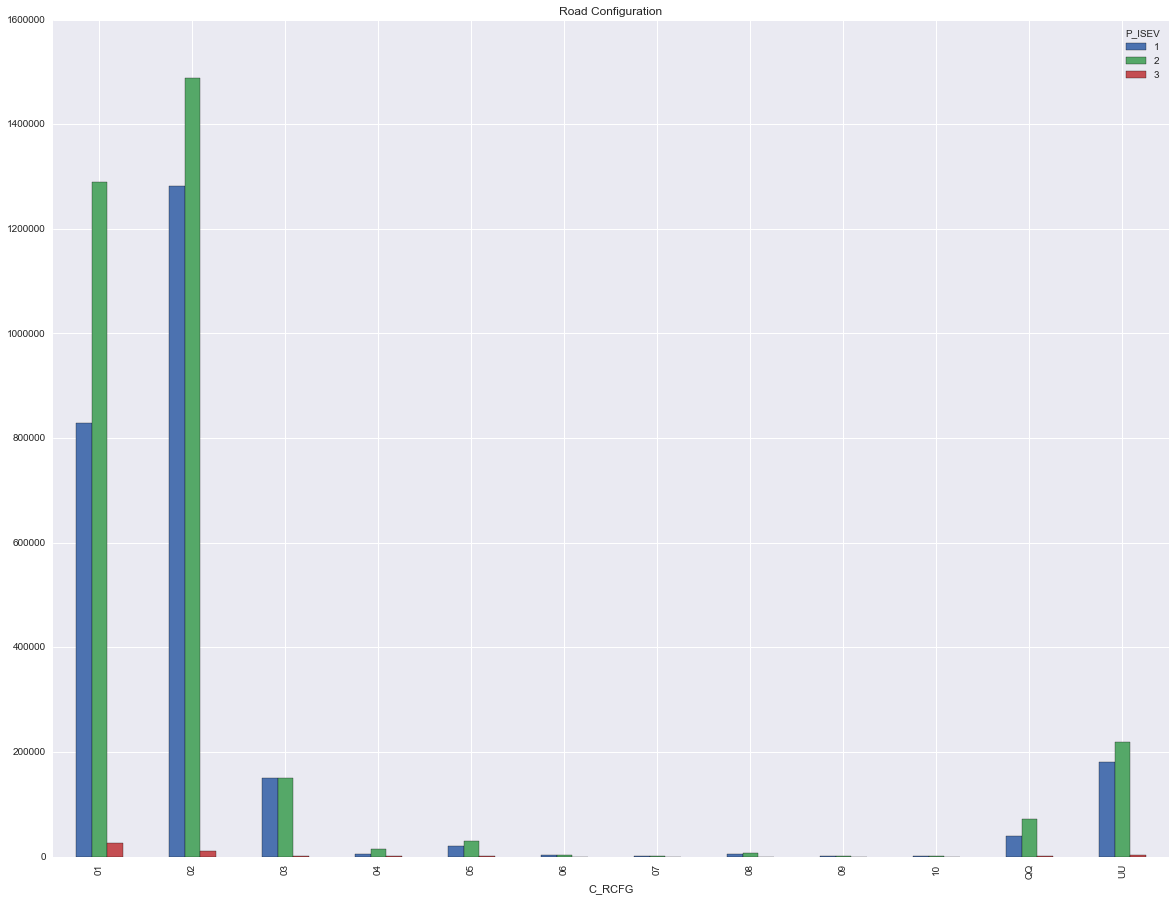

In [24]:
#Clean Road configuraiton
print("{count} non-numeric rows observed".format(count = df['C_RCFG'].astype('str').str.contains('[^0-9]').sum()))
by_road_config = df.groupby(['C_RCFG','P_ISEV']).size().unstack()
plt_enabled = True
if (plt_enabled):
    plot = by_road_config.plot(figsize=(20,15), kind='bar',title='Road Configuration', stacked = False);

N = by_road_config[0:len(by_road_config.index) - 2].sum().sum()
N1 = by_road_config[0:len(by_road_config.index) - 1].sum()
print (N)
#calculate the probability of the each category
P=[]
for cfg in by_road_config.index[0:len(by_road_config.index) - 2]:
    #print(cfg)
    p = by_road_config.loc[cfg].sum()/N
    P.append(p)
    #print(P)
np.sum(P)
#df['C_RCFG'] = df['C_RCFG'].apply(lambda x: x.replace('UU', str(np.random.choice(np.arange(1, 11), p = P))))
df['C_RCFG'] = df['C_RCFG'].apply(lambda x: x.replace('UU', selectBin(1, 11, P, True)))
#df['C_RCFG'] = df['C_RCFG'].apply(lambda x: x.replace('QQ', str(np.random.choice(np.arange(1, 11), p = P))))
df['C_RCFG'] = df['C_RCFG'].apply(lambda x: x.replace('QQ', selectBin(1, 11, P, True)))
print("{count} non-numeric rows observed".format(count = df['C_RCFG'].astype('str').str.contains('[^0-9]').sum()))

In [25]:
by_road_config = df.groupby(['C_RCFG','P_ISEV']).size().unstack()
plt_enabled = False
if (plt_enabled):
    plot = by_road_config.plot(figsize=(20,15), kind='bar',title='Road Configuration', stacked = False);


### Code for testing, should be removed

In [26]:
L3 = createDataframe()
print(L3)

    Col1 Col2 Col3
foo               
0      1    2    1
1      2    3    2
2      U    4    3
3      1    4    1
4      N    6    2
5      3    7    3
6      1    N    2
7      2    3    3
8      3    U    3
9      2    3    3
10     3    3    3
11     1    3    3


2 non-numeric rows observed


Col3,1,2,3
Col2,,,
2,1.0,NaN,NaN
3,NaN,1.0,4.0
4,1.0,NaN,1.0
6,NaN,1.0,NaN
7,NaN,NaN,1.0
N,NaN,1.0,NaN
U,NaN,NaN,1.0


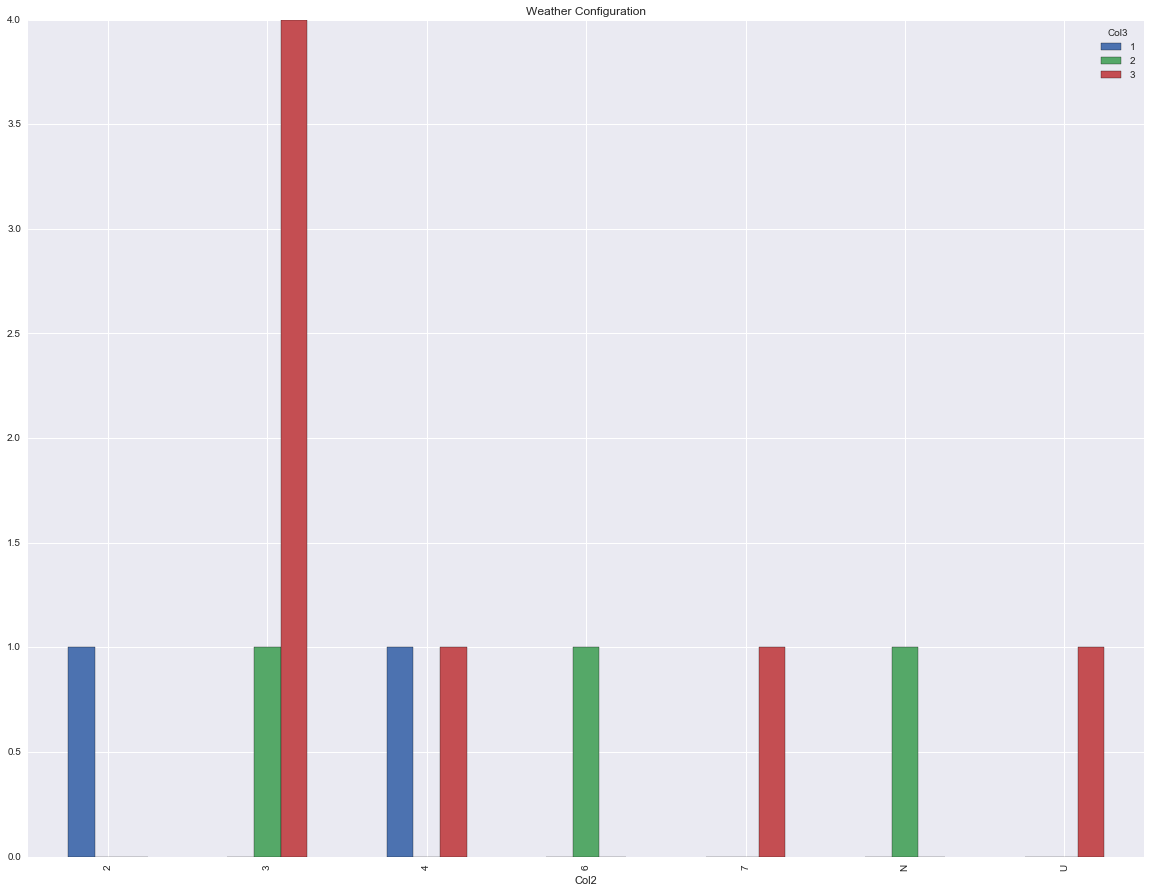

In [27]:
print("{count} non-numeric rows observed".format(count = L3['Col2'].astype('str').str.contains('[^0-9]').sum()))
L1 = checkHistogram(L3, 'Col2', 'Col3', True)
L1

In [28]:
print(L1.index[L1.index.astype('str').str.contains('[0-9]')])
print(L1.index[L1.index.astype('str').str.contains('[^0-9]')])
print(L1.index[L1.index.astype('str').str.contains('[0-9]')].max())

Index(['2', '3', '4', '6', '7'], dtype='object', name='Col2')
Index(['N', 'U'], dtype='object', name='Col2')
7


In [29]:
debug = True
P = computeP(L1)
#df['C_RCFG'] = df['C_RCFG'].apply(lambda x: x.replace('UU', rcfg(1, 11, P)))
#df['C_RCFG'] = df['C_RCFG'].apply(lambda x: x.replace('QQ', rcfg(1, 11, P)))
#print("{count} non-numeric rows observed".format(count = df['C_RCFG'].astype('str').str.contains('[^0-9]').sum()))

Col3    1    2    3
Col2               
2     1.0  NaN  NaN
3     NaN  1.0  4.0
4     1.0  NaN  1.0
6     NaN  1.0  NaN
7     NaN  NaN  1.0
10.0
ind: 2
cur: 1
i: 1
ind: 3
cur: 3
ind: 4
cur: 4
ind: 6
cur: 5
i: 5
ind: 7
cur: 7
[0, 0.1, 0.5, 0.2, 0, 0.1, 0.1]
1.0


In [30]:
print(P)

[0, 0.1, 0.5, 0.2, 0, 0.1, 0.1]


In [31]:
L3['Col2'] = L3['Col2'].apply(lambda x: x.replace('U', selectBin(1, 8, P, False)))

Col3,1,2,3
Col2,,,
2,1.0,NaN,NaN
3,NaN,1.0,4.0
4,1.0,NaN,2.0
6,NaN,1.0,NaN
7,NaN,NaN,1.0
N,NaN,1.0,NaN


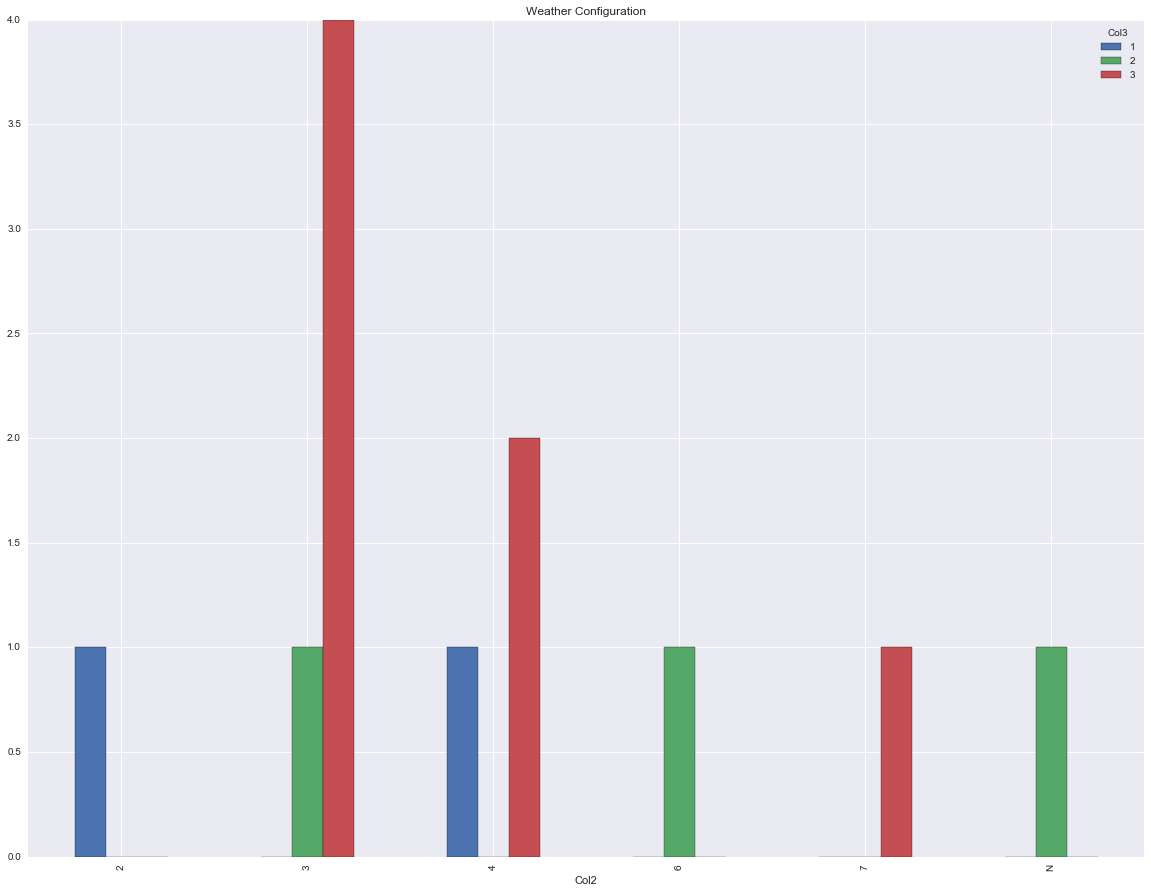

In [32]:
checkHistogram(L3, 'Col2', 'Col3', True)

### end of test code

42112 non-numeric rows observed


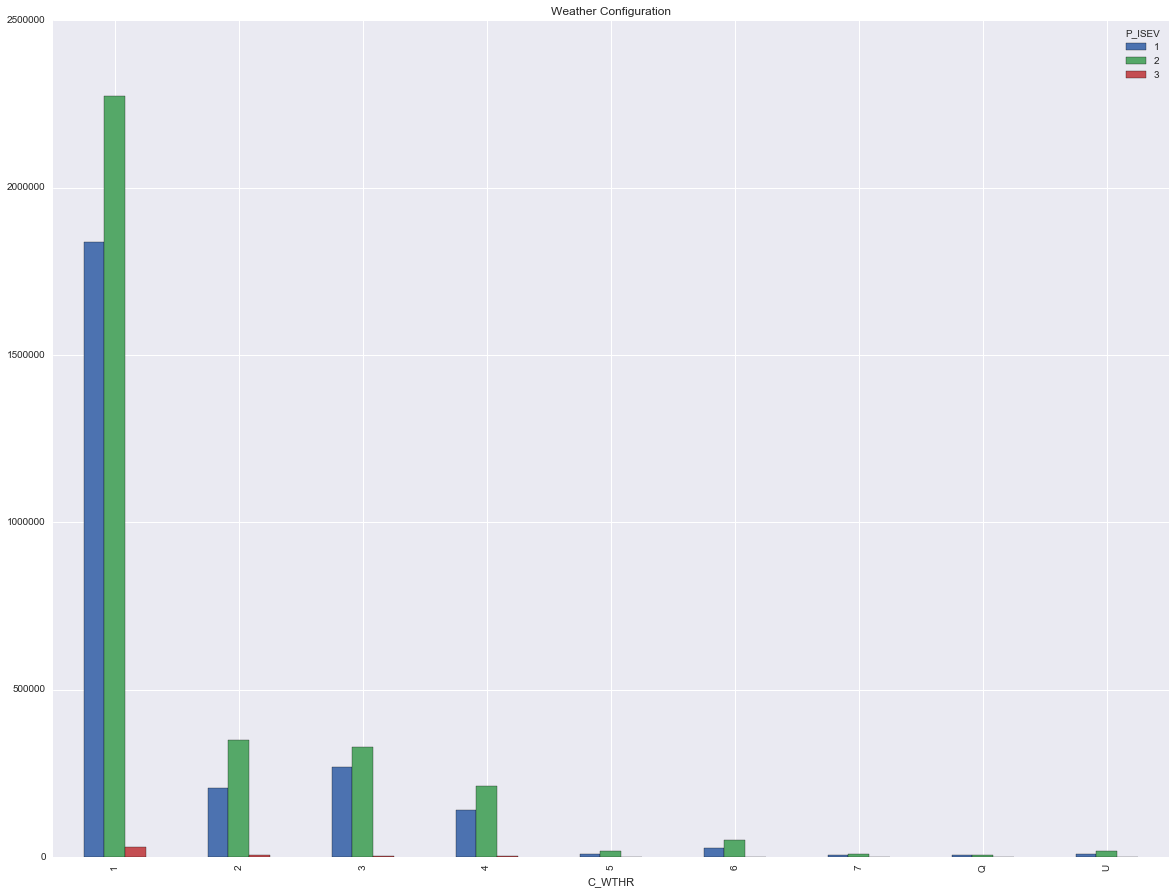

In [33]:
#Clean Weather
#C_WTHR

print("{count} non-numeric rows observed".format(count = df['C_WTHR'].astype('str').str.contains('[^0-9]').sum()))
gbWTHR = checkHistogram(df, 'C_WTHR', 'P_ISEV', True)

In [34]:
#compute probability of each level not including unknows
P = computeP(gbWTHR)

P_ISEV        1        2      3
C_WTHR                         
1       1836030  2272399  29669
2        207631   348821   5803
3        269328   330238   3666
4        140780   213118   2666
5         10557    19697    300
6         28390    52681   1240
7          5256    10171    249
5788690
ind: 1
cur: 1
ind: 2
cur: 2
ind: 3
cur: 3
ind: 4
cur: 4
ind: 5
cur: 5
ind: 6
cur: 6
ind: 7
cur: 7
[0.7148591477519093, 0.09712992058652303, 0.10420872425367397, 0.061596665221319506, 0.005278223570445126, 0.01421927931880961, 0.002708039297319428]
1.0


In [35]:
#impute unkown values
df['C_WTHR'] = df['C_WTHR'].apply(lambda x: x.replace('Q', selectBin(1, 8, P, False)))
df['C_WTHR'] = df['C_WTHR'].apply(lambda x: x.replace('U', selectBin(1, 8, P, False)))
print("{count} non-numeric rows observed".format(count = df['C_WTHR'].astype('str').str.contains('[^0-9]').sum()))

0 non-numeric rows observed


P_ISEV,1,2,3
C_WTHR,,,
1,1847020,2291123,30082
2,209172,351352,5849
3,270898,333024,3737
4,141673,214720,2701
5,10623,19847,303
6,28600,53041,1246
7,5295,10247,249


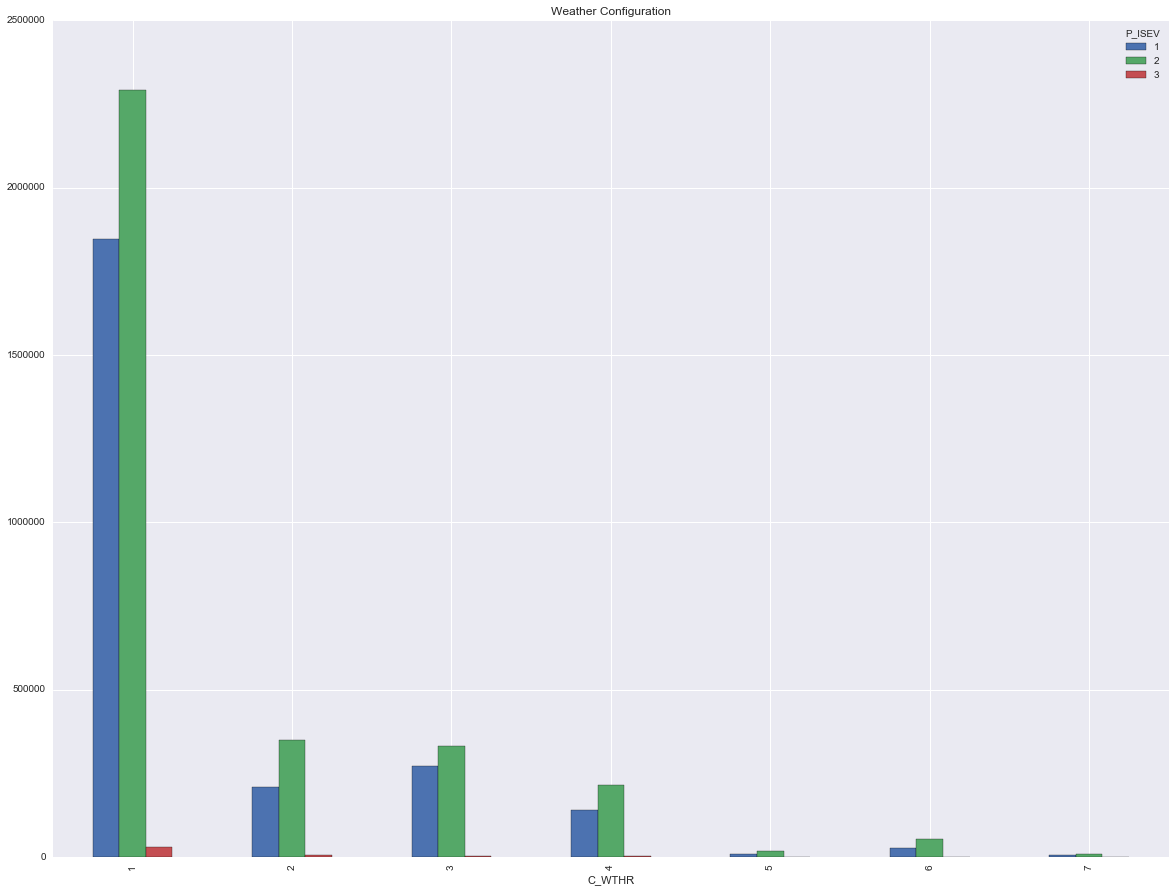

In [36]:
#check histogram for new distribution
checkHistogram(df, 'C_WTHR', 'P_ISEV', True)

184598 non-numeric rows observed


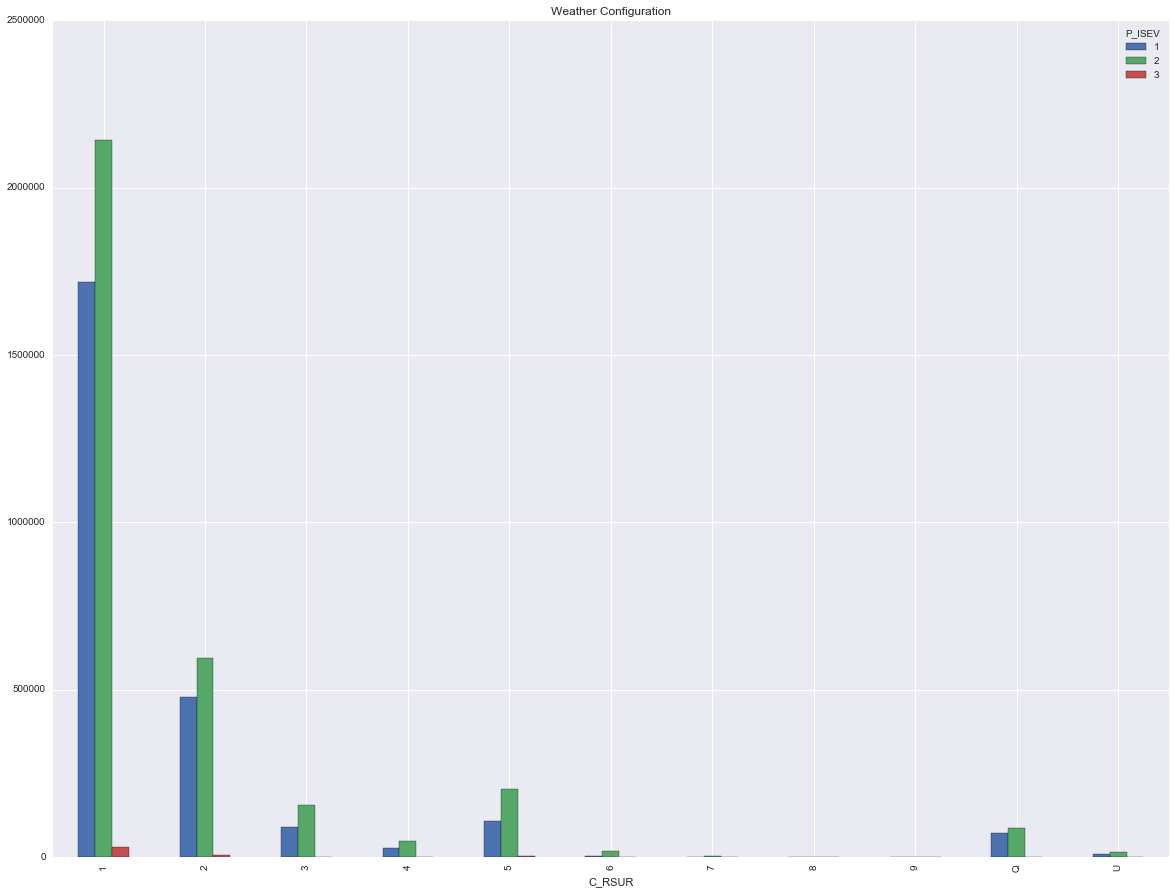

In [37]:
#Clean road surface
#C_RSUR
print("{count} non-numeric rows observed".format(count = df['C_RSUR'].astype('str').str.contains('[^0-9]').sum()))
gbRSUR = checkHistogram(df, 'C_RSUR', 'P_ISEV', True)

In [38]:
#compute probability of each road surface condition in our data set not including unknows
P = computeP(gbRSUR)

P_ISEV        1        2      3
C_RSUR                         
1       1719454  2143543  29799
2        479590   594951   6851
3         89934   157168   1876
4         28585    46954    623
5        107362   204990   2485
6          4880    19547    543
7          1462     3960    125
8           315      901      2
9            79      217      8
5646204
ind: 1
cur: 1
ind: 2
cur: 2
ind: 3
cur: 3
ind: 4
cur: 4
ind: 5
cur: 5
ind: 6
cur: 6
ind: 7
cur: 7
ind: 8
cur: 8
ind: 9
cur: 9
[0.6894536577141032, 0.19152549217137743, 0.04409652927878624, 0.013489062740205632, 0.05576082621173447, 0.004422440280230753, 0.0009824299653360027, 0.0002157201546384084, 5.384148358791146e-05]
1.0


In [39]:
#impute unkown values
df['C_RSUR'] = df['C_RSUR'].apply(lambda x: x.replace('Q', selectBin(1, 10, P, False)))
df['C_RSUR'] = df['C_RSUR'].apply(lambda x: x.replace('U', selectBin(1, 10, P, False)))
print("{count} non-numeric rows observed".format(count = df['C_RSUR'].astype('str').str.contains('[^0-9]').sum()))

0 non-numeric rows observed


0 non-numeric rows observed


P_ISEV,1,2,3
C_RSUR,,,
1,1775805,2213109,31053
2,495107,614382,7217
3,93546,161659,1967
4,29609,48347,648
5,112001,210644,2598
6,5247,20005,549
7,1551,4066,125
8,334,919,2
9,81,223,8


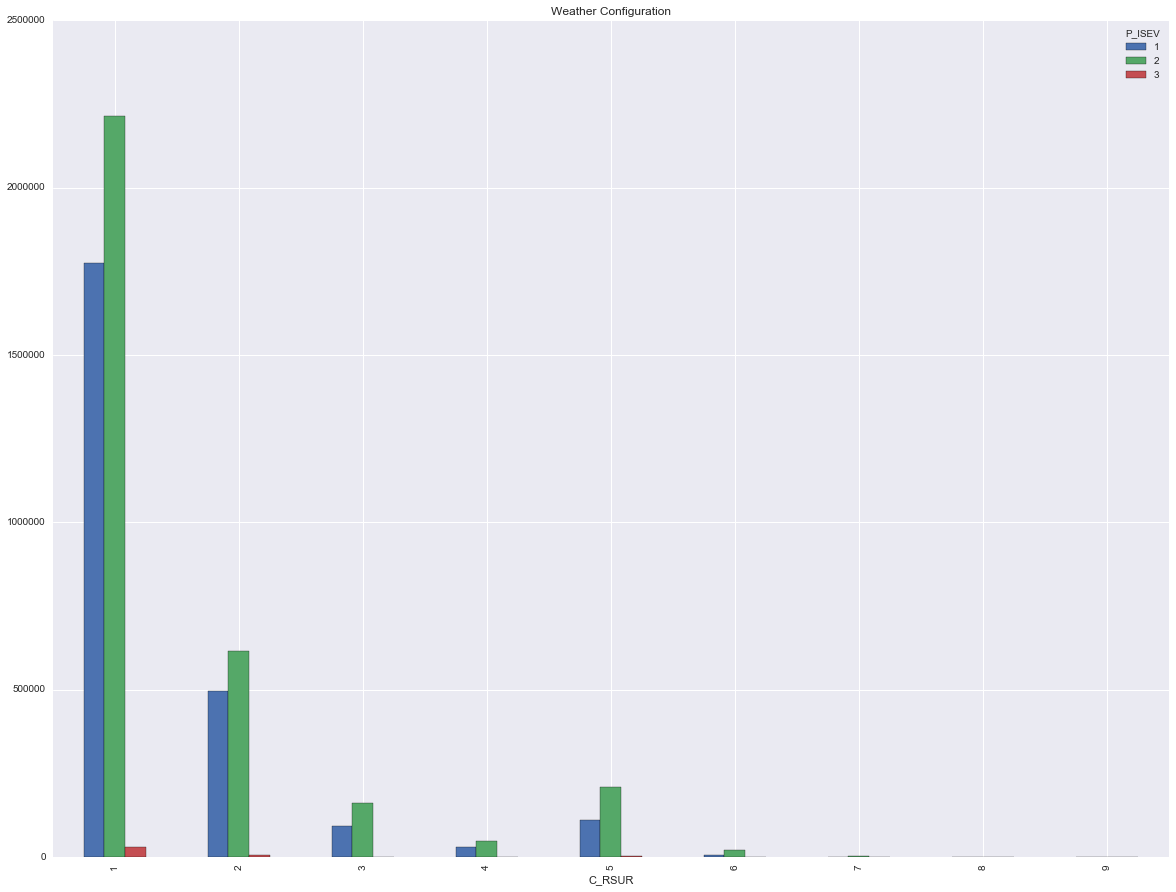

In [40]:
#Clean road surface
print("{count} non-numeric rows observed".format(count = df['C_RSUR'].astype('str').str.contains('[^0-9]').sum()))
checkHistogram(df, 'C_RSUR', 'P_ISEV', True)

367464 non-numeric rows observed


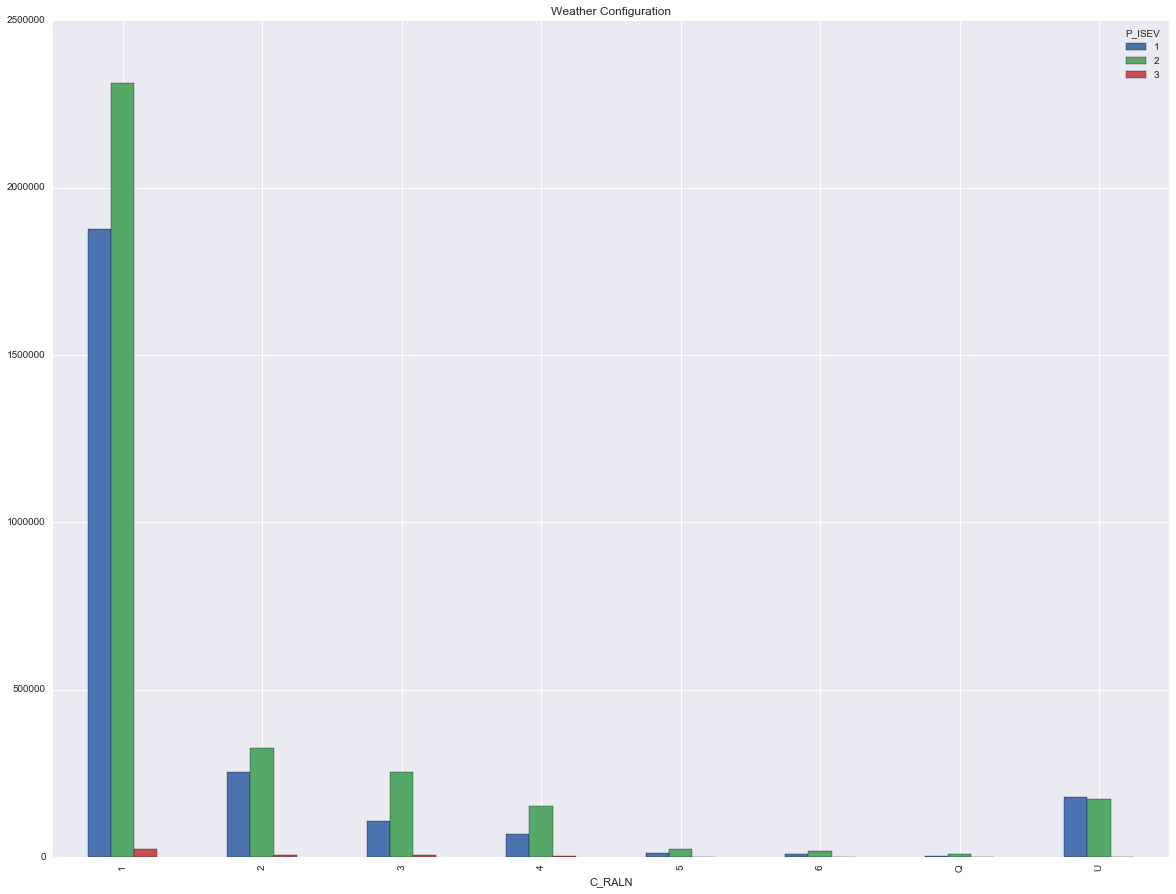

In [41]:
#road alignment
#C_RALN
print("{count} non-numeric rows observed".format(count = df['C_RALN'].astype('str').str.contains('[^0-9]').sum()))
gbRALG = checkHistogram(df, 'C_RALN', 'P_ISEV', True)

P_ISEV        1        2      3
C_RALN                         
1       1875695  2312248  25061
2        253580   326791   5282
3        108617   253508   6802
4         69776   153605   4359
5         13646    25308    560
6          9023    19024    453
5463338
ind: 1
cur: 1
ind: 2
cur: 2
ind: 3
cur: 3
ind: 4
cur: 4
ind: 5
cur: 5
ind: 6
cur: 6
[0.7711410130583171, 0.10719691880678077, 0.06752776416176337, 0.04168513827993069, 0.0072325746640606895, 0.005216591029147382]
1.0
0 non-numeric rows observed


P_ISEV,1,2,3
C_RALN,,,
1,2016720,2452981,26341
2,273084,346559,5435
3,121134,265942,6929
4,77372,161324,4431
5,14948,26625,570
6,10023,19923,461


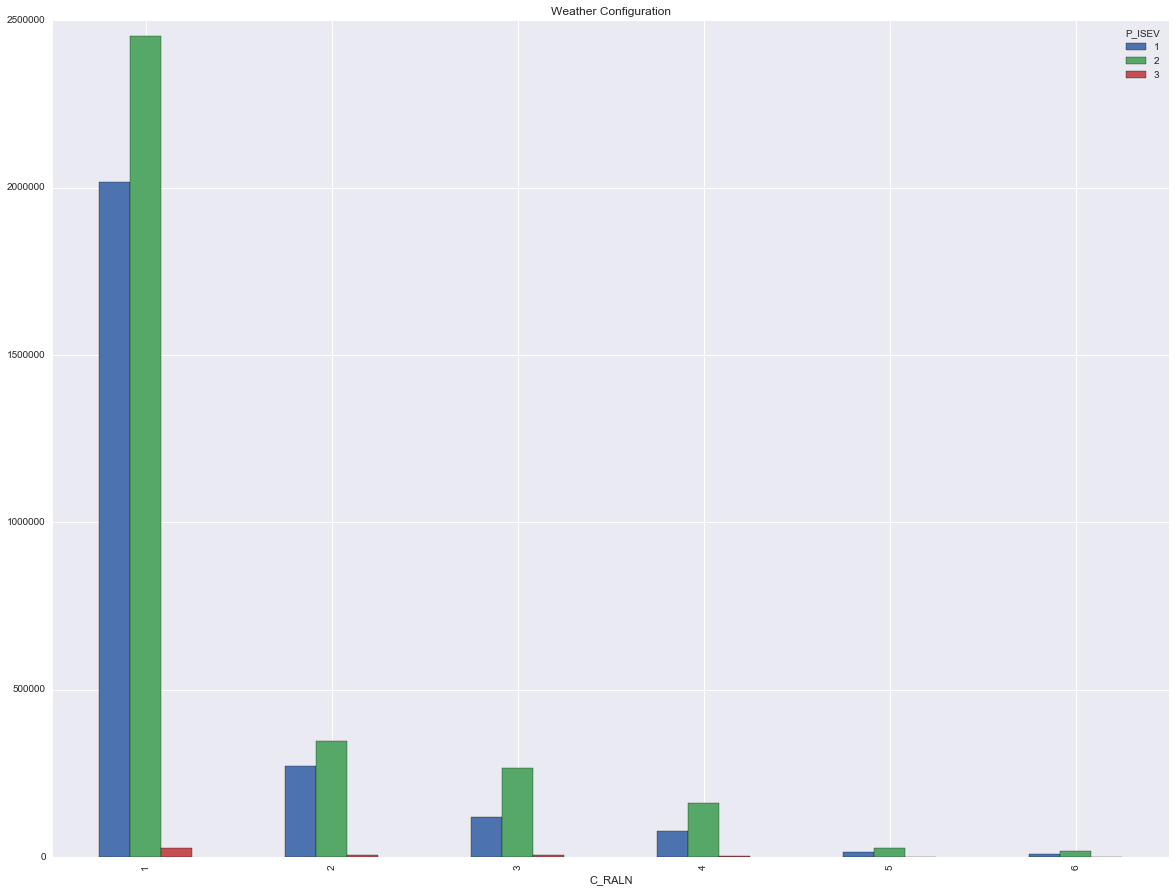

In [42]:
#compute probability of each road alignment in our data set not including unknows
P = computeP(gbRALG)

#impute unkown values
df['C_RALN'] = df['C_RALN'].apply(lambda x: x.replace('Q', selectBin(1, 7, P, False)))
df['C_RALN'] = df['C_RALN'].apply(lambda x: x.replace('U', selectBin(1, 7, P, False)))
print("{count} non-numeric rows observed".format(count = df['C_RALN'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'C_RALN', 'P_ISEV', True)

In [43]:
df.dtypes

C_YEAR     int64
C_MNTH    object
C_WDAY    object
C_HOUR    object
C_VEHS    object
C_CONF    object
C_RCFG    object
C_WTHR    object
C_RSUR    object
C_RALN    object
C_TRAF    object
V_ID      object
V_TYPE    object
V_YEAR    object
P_ID      object
P_SEX     object
P_AGE     object
P_PSN     object
P_SAFE    object
P_USER    object
P_ISEV    object
dtype: object

228554 non-numeric rows observed


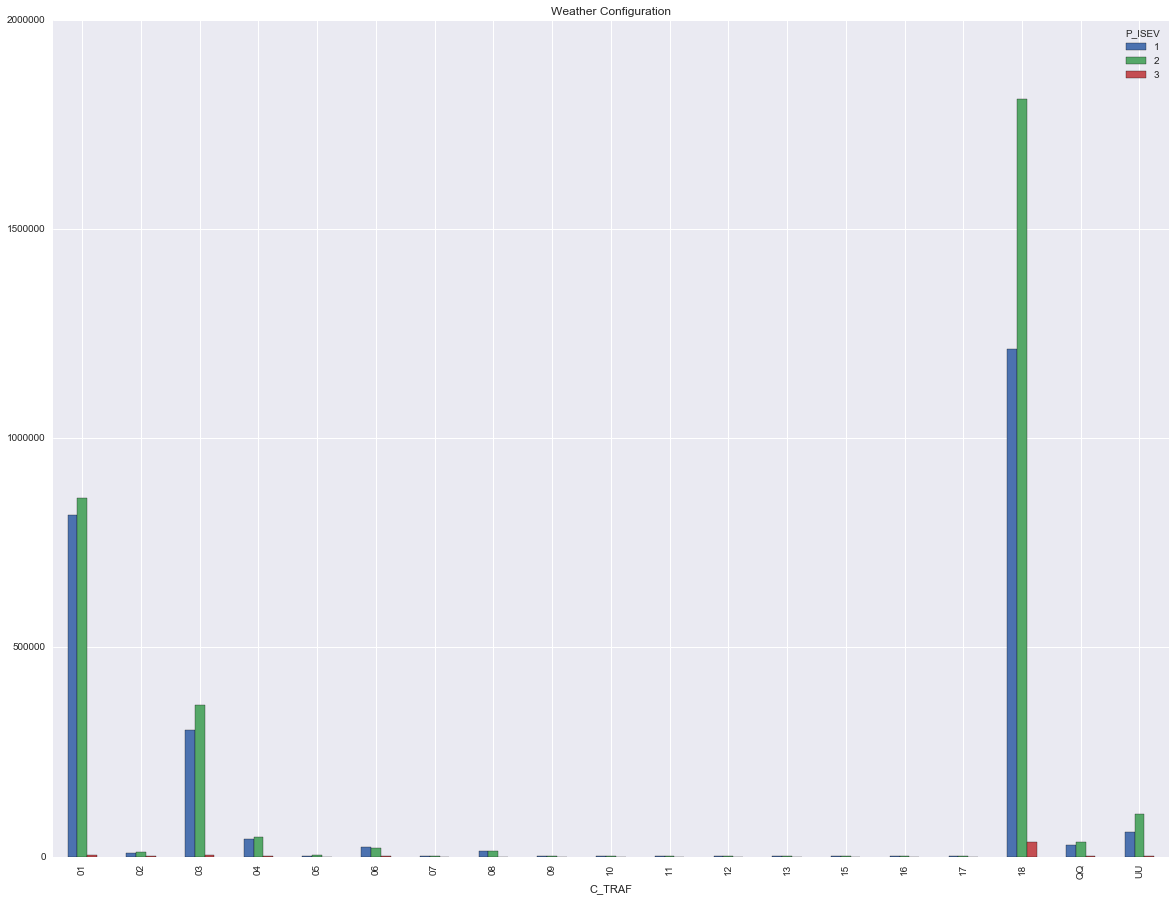

In [44]:
#C_TRAF
#Traffic configuration
print("{count} non-numeric rows observed".format(count = df['C_TRAF'].astype('str').str.contains('[^0-9]').sum()))
gbTRAF = checkHistogram(df, 'C_TRAF', 'P_ISEV', True)

P_ISEV        1        2      3
C_TRAF                         
01       816692   855705   3317
02         7877    10803    154
03       302141   362399   3512
04        42668    47190    223
05          856     2854     82
06        22141    19930    169
07         1157     1145     10
08        12662    12271     69
09          198      300      1
10          652     1794     66
11          493     2253     73
12         1056     1748     59
13         2205     2067     11
15         1169     2262    107
16          213      625     51
17         1180     1651     35
18      1211997  1810042  33913
5602248
ind: 01
cur: 1
ind: 02
cur: 2
ind: 03
cur: 3
ind: 04
cur: 4
ind: 05
cur: 5
ind: 06
cur: 6
ind: 07
cur: 7
ind: 08
cur: 8
ind: 09
cur: 9
ind: 10
cur: 10
ind: 11
cur: 11
ind: 12
cur: 12
ind: 13
cur: 13
ind: 15
cur: 14
i: 14
ind: 16
cur: 16
ind: 17
cur: 17
ind: 18
cur: 18
[0.2991145697227256, 0.0033618647371555133, 0.11924713079463815, 0.016079438111272475, 0.0006768711417273923, 0.007

P_ISEV,1,2,3
C_TRAF,,,
01,843012,896961,3988
02,8185,11294,163
03,312554,378856,3796
04,44124,49403,269
05,920,2924,82
06,22800,21017,191
07,1198,1206,10
08,13072,12880,80
09,205,318,1


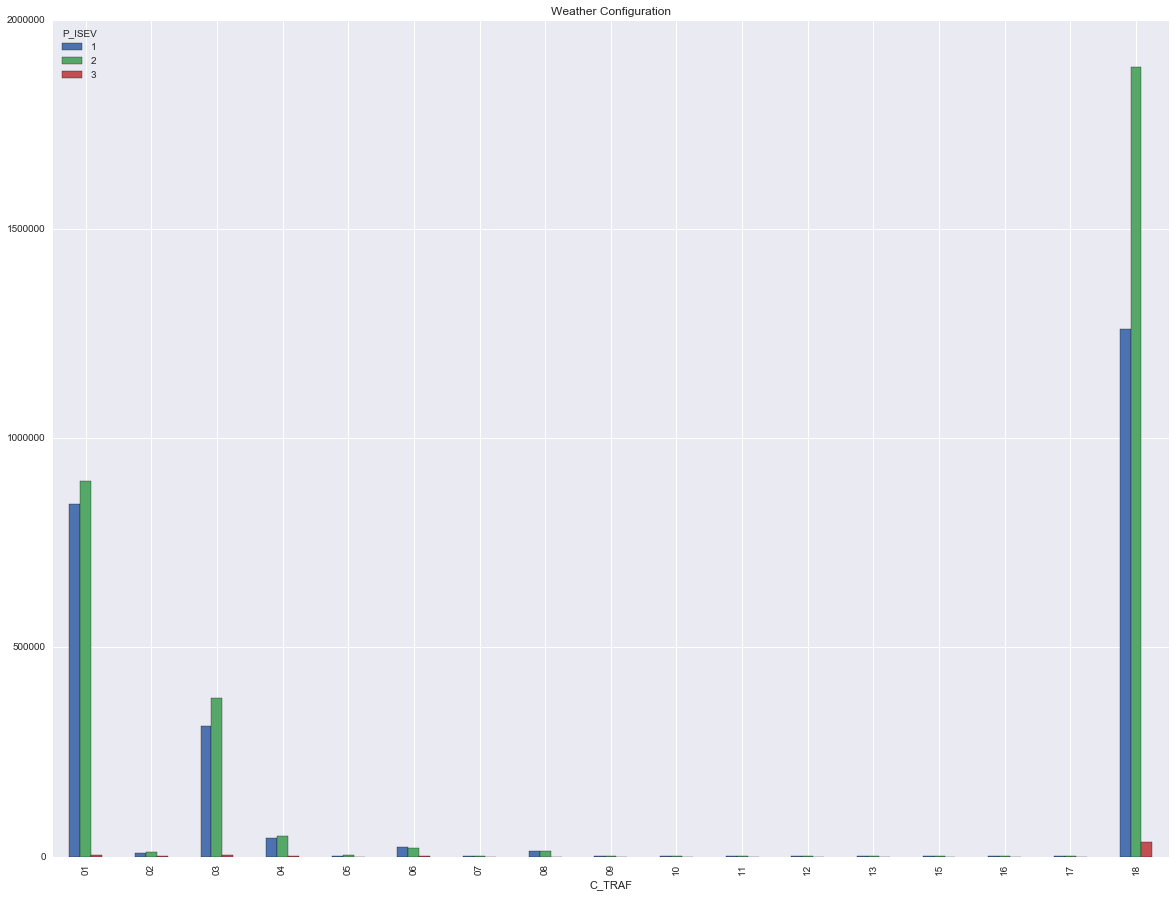

In [45]:
#compute probability of each road alignment in our data set not including unknows
#note, school bus zone has no value
P = computeP(gbTRAF)

#impute unkown values
df['C_TRAF'] = df['C_TRAF'].apply(lambda x: x.replace('QQ', selectBin(1, 19, P, True)))
df['C_TRAF'] = df['C_TRAF'].apply(lambda x: x.replace('UU', selectBin(1, 19, P, True)))
print("{count} non-numeric rows observed".format(count = df['C_TRAF'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'C_TRAF', 'P_ISEV', True)

In [46]:
df.columns

Index(['C_YEAR', 'C_MNTH', 'C_WDAY', 'C_HOUR', 'C_VEHS', 'C_CONF', 'C_RCFG',
       'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_ID', 'V_TYPE', 'V_YEAR',
       'P_ID', 'P_SEX', 'P_AGE', 'P_PSN', 'P_SAFE', 'P_USER', 'P_ISEV'],
      dtype='object')

7 non-numeric rows observed


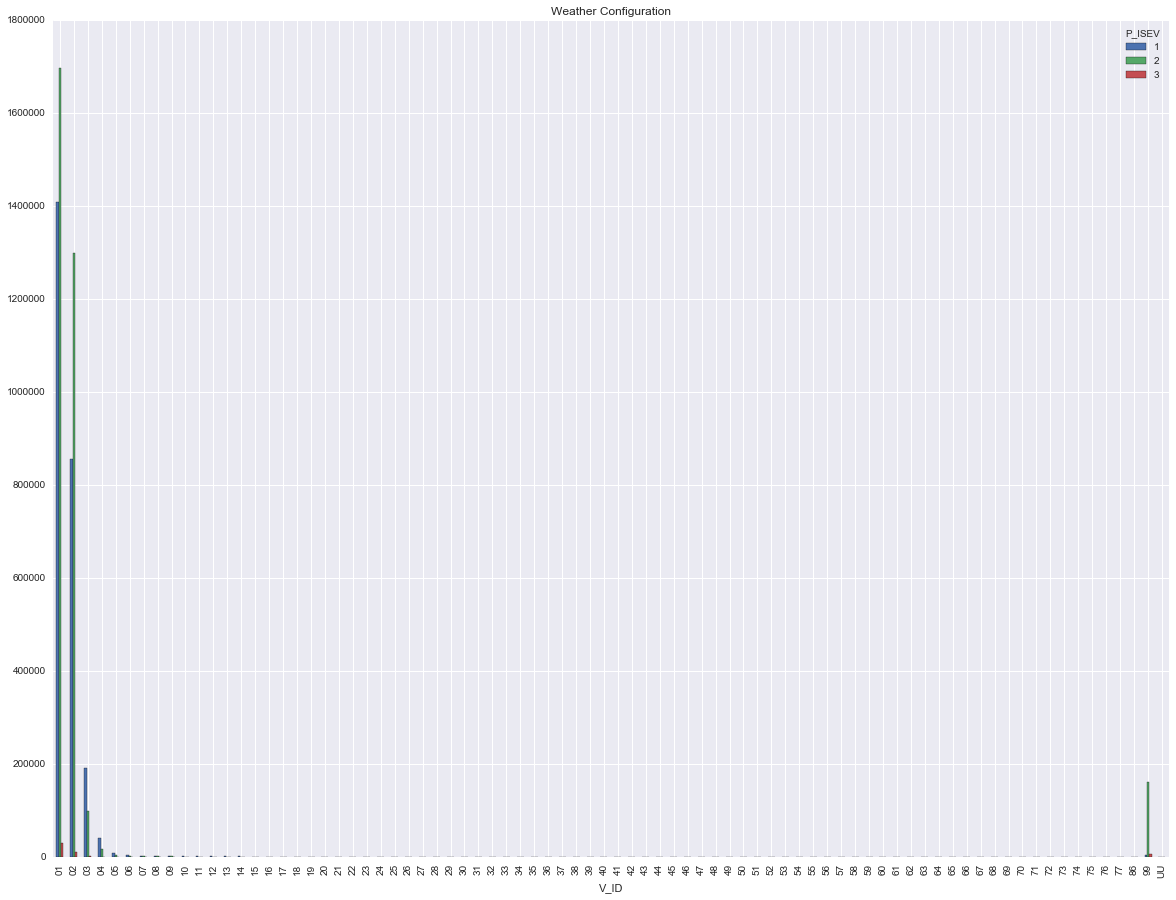

In [47]:
#vehicle if
print("{count} non-numeric rows observed".format(count = df['V_ID'].astype('str').str.contains('[^0-9]').sum()))
gbVID = checkHistogram(df, 'V_ID', 'P_ISEV', True)

P_ISEV          1          2        3
V_ID                                 
01      1408184.0  1696714.0  28536.0
02       856020.0  1297746.0   8890.0
03       190474.0    97997.0    400.0
04        39368.0    15268.0     82.0
05         8649.0     3028.0     36.0
06         2682.0      987.0      9.0
07         1133.0      443.0      5.0
08          620.0      258.0      3.0
09          447.0      190.0      4.0
10          258.0      101.0      NaN
11          218.0       81.0      3.0
12          158.0       79.0      2.0
...           ...        ...      ...
68            2.0        1.0      NaN
69            3.0        NaN      NaN
70            3.0        NaN      NaN
71            2.0        1.0      NaN
72            3.0        5.0      1.0
73            1.0        2.0      NaN
74            1.0        NaN      NaN
75            1.0        NaN      NaN
76            1.0        2.0      NaN
77            1.0        1.0      NaN
86            1.0        1.0      NaN
99         3

P_ISEV,1,2,3
V_ID,,,
01,1408184.0,1696714.0,28542.0
02,856020.0,1297746.0,8890.0
03,190474.0,97997.0,400.0
04,39368.0,15268.0,82.0
05,8649.0,3028.0,36.0
06,2682.0,987.0,9.0
07,1133.0,443.0,5.0
08,620.0,258.0,3.0
09,447.0,190.0,4.0


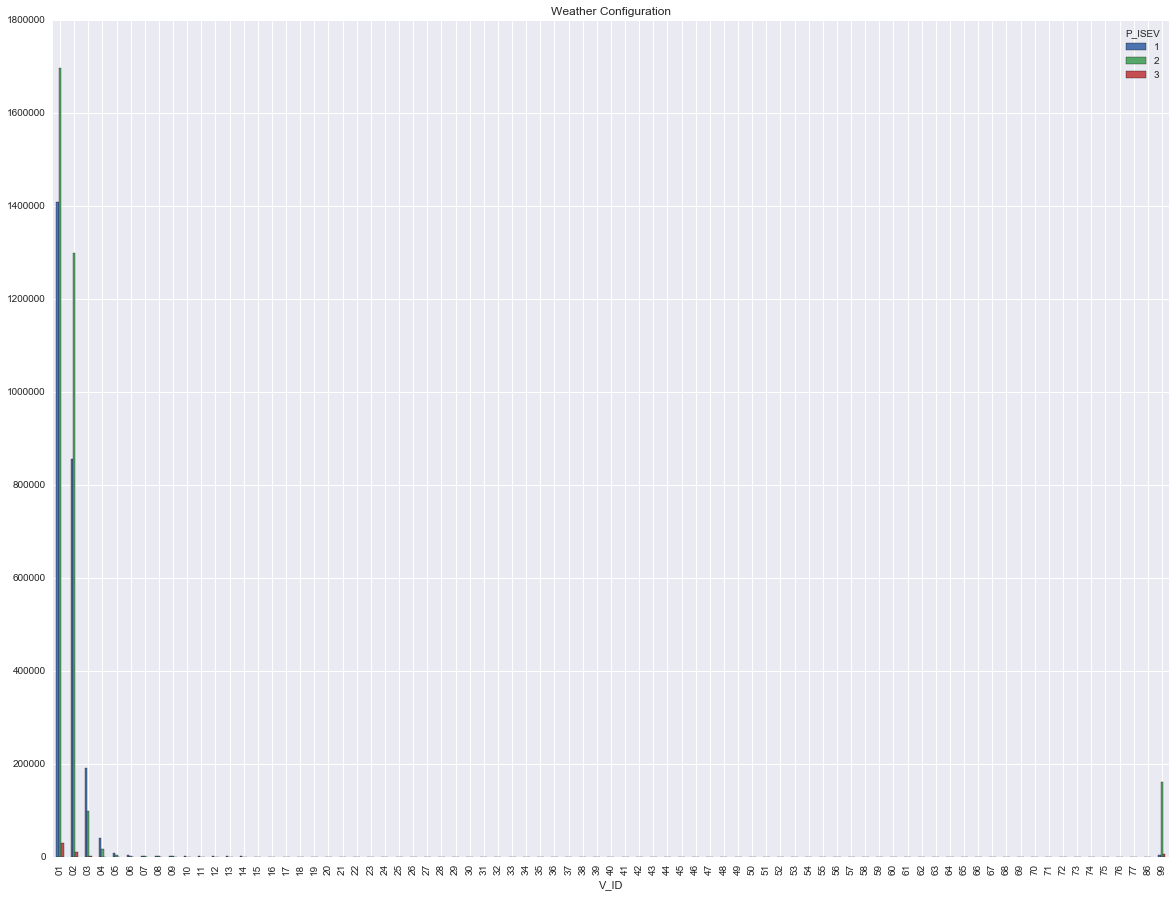

In [48]:
#compute probability of each road alignment in our data set not including unknows
#note, school bus zone has no value
P = computeP(gbVID)

#impute unkown values
df['V_ID'] = df['V_ID'].apply(lambda x: x.replace('UU', selectBin(1, 100, P, True)))
print("{count} non-numeric rows observed".format(count = df['C_TRAF'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'V_ID', 'P_ISEV', True)

27161 non-numeric rows observed


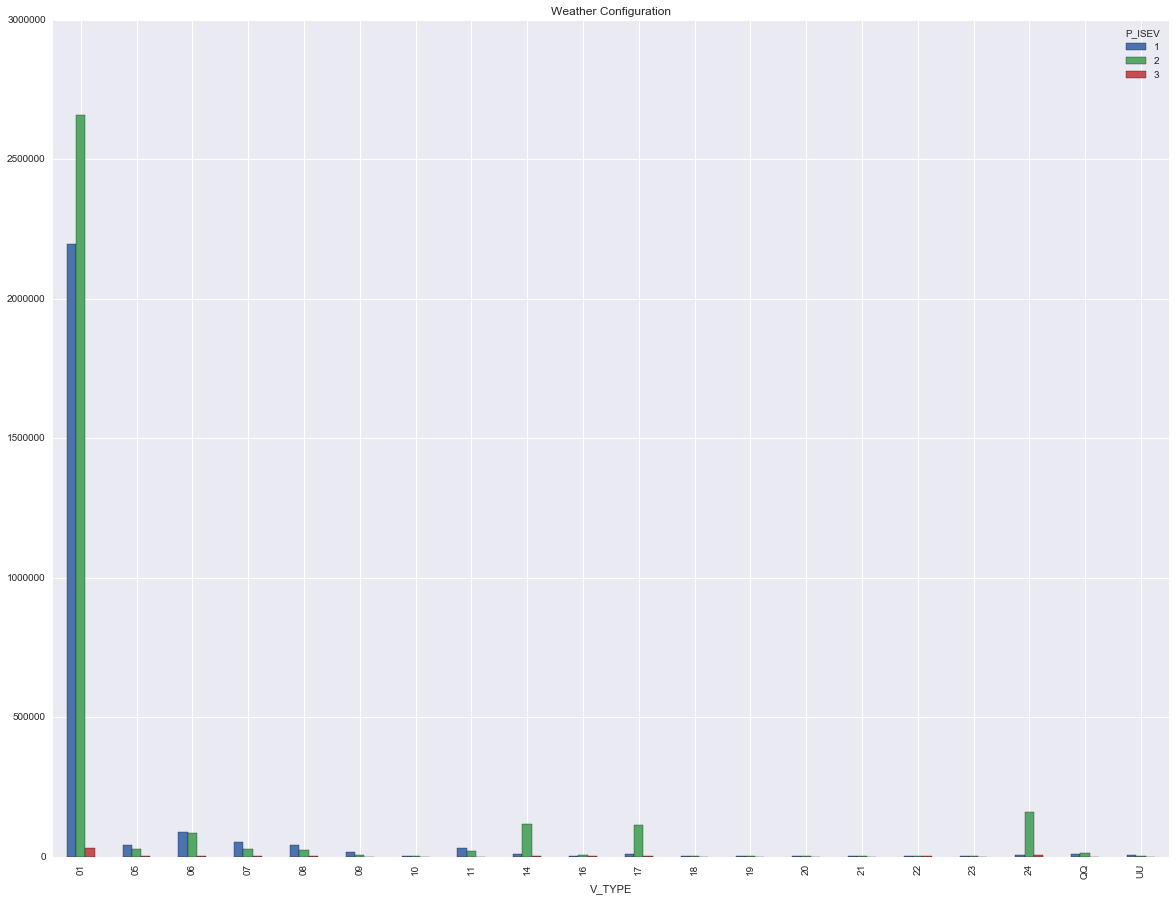

In [49]:
#V_TYPE
#change NN to 24
df['V_TYPE'] = df['V_TYPE'].apply(lambda x: x.replace('NN', '24'))

print("{count} non-numeric rows observed".format(count = df['V_TYPE'].astype('str').str.contains('[^0-9]').sum()))
gbVTYPE = checkHistogram(df, 'V_TYPE', 'P_ISEV', True)

P_ISEV          1          2        3
V_TYPE                               
01      2196454.0  2658575.0  29317.0
05        41255.0    28504.0    316.0
06        88145.0    85602.0   1365.0
07        53002.0    28806.0    518.0
08        41594.0    23072.0    742.0
09        15261.0     6162.0     18.0
10          625.0      365.0      1.0
11        30270.0    19928.0     83.0
14        10891.0   118315.0   3487.0
16         1239.0     6789.0    456.0
17         7927.0   114159.0   1003.0
18         1882.0     1253.0     34.0
19         1249.0      581.0     45.0
20         3300.0     1790.0    111.0
21          684.0      207.0      2.0
22          484.0     2835.0    263.0
23         2347.0      884.0      NaN
24         4664.0   160586.0   6194.0
5803641.0
ind: 01
cur: 1
ind: 05
cur: 2
i: 2
i: 3
i: 4
ind: 06
cur: 6
ind: 07
cur: 7
ind: 08
cur: 8
ind: 09
cur: 9
ind: 10
cur: 10
ind: 11
cur: 11
ind: 14
cur: 12
i: 12
i: 13
ind: 16
cur: 15
i: 15
ind: 17
cur: 17
ind: 18
cur: 18
ind: 19
cur

P_ISEV,1,2,3
V_TYPE,,,
01,2206603.0,2671131.0,29495.0
05,41405.0,28663.0,321.0
06,88513.0,86052.0,1373.0
07,53172.0,29036.0,520.0
08,41718.0,23214.0,746.0
09,15306.0,6216.0,21.0
10,625.0,369.0,1.0
11,30365.0,20075.0,83.0
14,11176.0,118678.0,3489.0


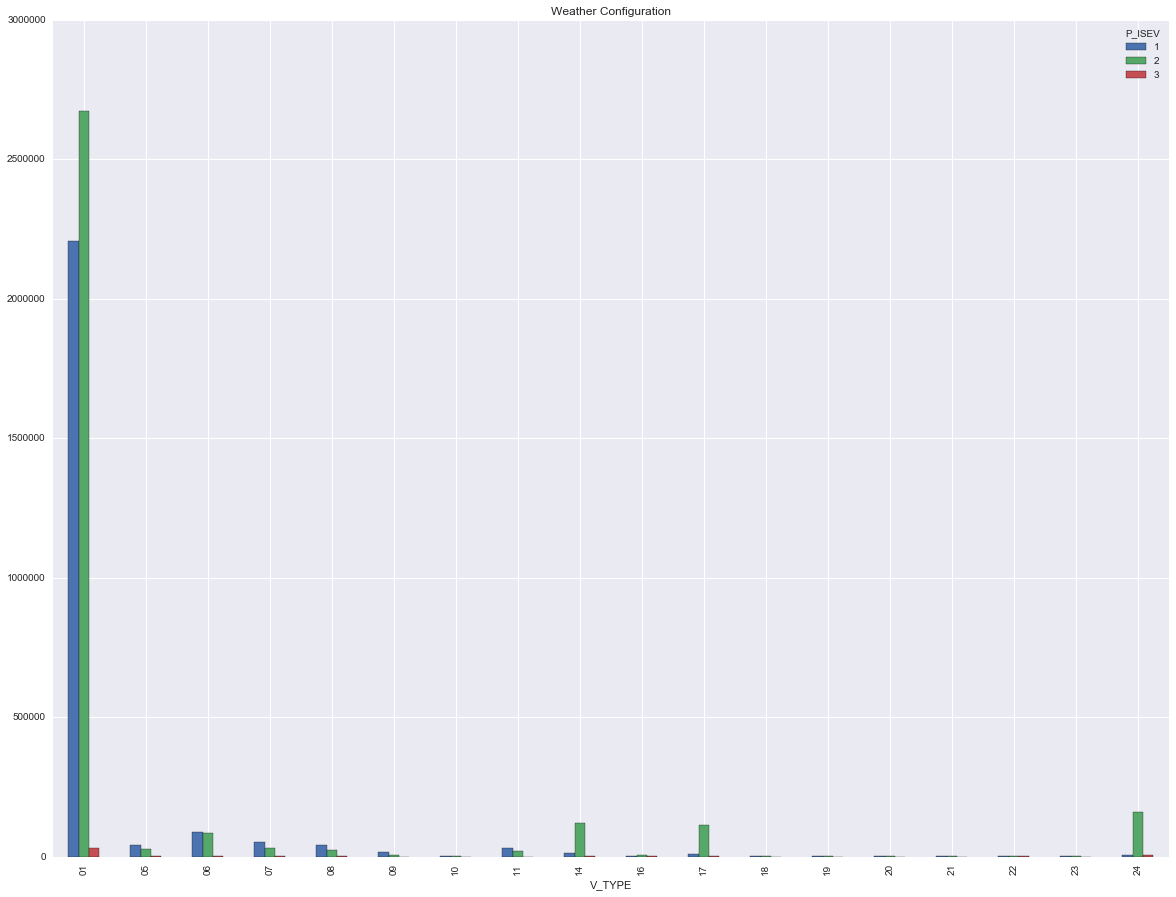

In [50]:
#compute probability of each road alignment in our data set not including unknows
#note, school bus zone has no value
P = computeP(gbVTYPE)

#impute unkown values
df['V_TYPE'] = df['V_TYPE'].apply(lambda x: x.replace('UU', selectBin(1, 25, P, True)))
df['V_TYPE'] = df['V_TYPE'].apply(lambda x: x.replace('QQ', selectBin(1, 25, P, True)))
print("{count} non-numeric rows observed".format(count = df['V_TYPE'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'V_TYPE', 'P_ISEV', True)

236056 non-numeric rows observed


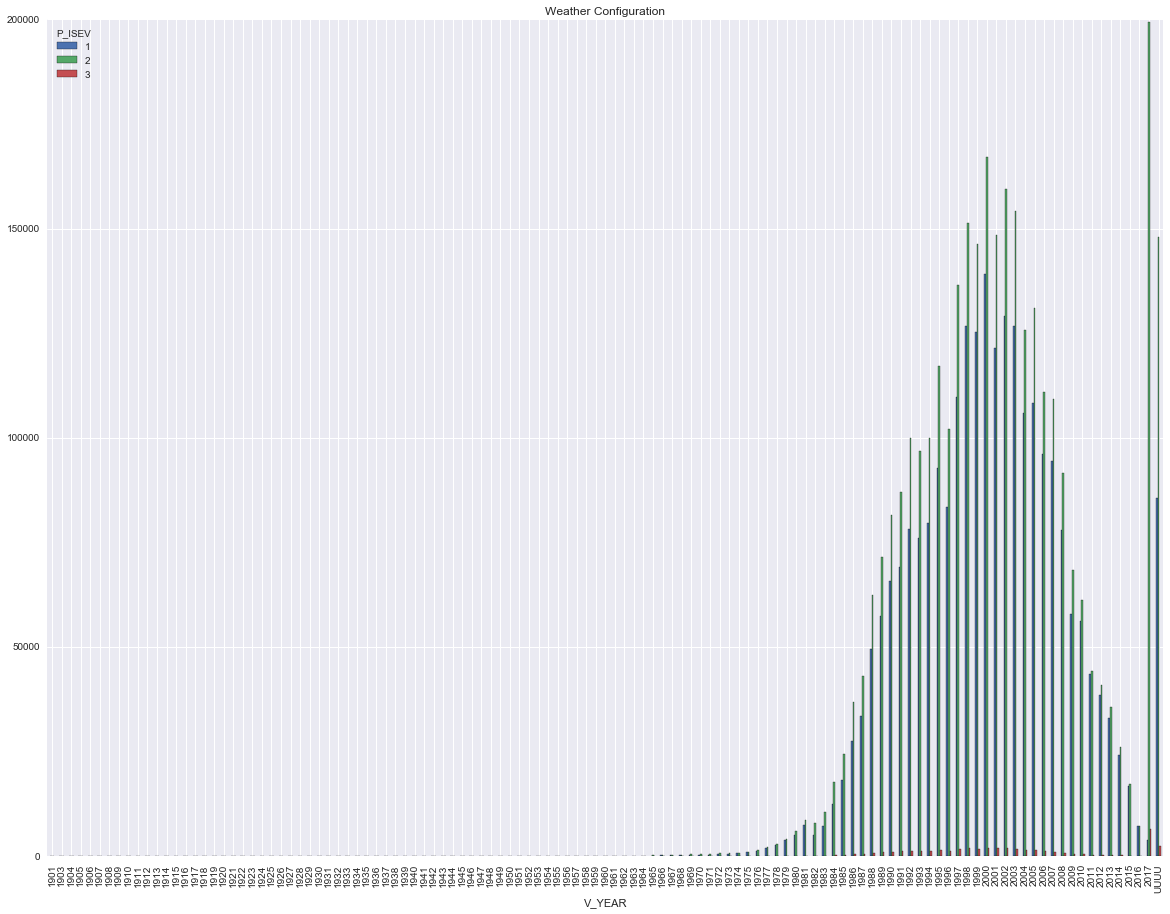

In [51]:
#V_YEAR - Vehicle Year
df['V_YEAR'] = df['V_YEAR'].apply(lambda x: x.replace('NNNN', '2017'))

#For now set UUUU to year 2018, unti we find out why the code is not working
df['V_YEAR'] = df['V_YEAR'].apply(lambda x: x.replace('UUUU', '2018'))

print("{count} non-numeric rows observed".format(count = df['V_YEAR'].astype('str').str.contains('[^0-9]').sum()))
gbVYEAR = checkHistogram(df, 'V_YEAR', 'P_ISEV', True)

In [55]:
P = computeP(gbVYEAR)

#impute unkown values
#df['V_YEAR'] = df['V_YEAR'].apply(lambda x: x.replace('UUUU', selectBin(1, 118, P, True)))
#print("{count} non-numeric rows observed".format(count = df['V_YEAR'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
#checkHistogram(df, 'V_YEAR', 'P_ISEV', True)

P_ISEV        1         2       3
V_YEAR                           
1901        8.0       6.0     NaN
1903        3.0       5.0     NaN
1904        1.0       1.0     NaN
1905        NaN       3.0     NaN
1906        1.0       NaN     NaN
1907        1.0       1.0     NaN
1908        2.0       2.0     NaN
1909        1.0       NaN     NaN
1910        NaN       1.0     NaN
1911        8.0       2.0     NaN
1912        2.0       5.0     NaN
1913        1.0       3.0     NaN
...         ...       ...     ...
2006    96174.0  110906.0  1183.0
2007    94531.0  109344.0  1135.0
2008    78037.0   91474.0   899.0
2009    57832.0   68394.0   588.0
2010    56143.0   61362.0   485.0
2011    43657.0   44372.0   327.0
2012    38646.0   41043.0   331.0
2013    32997.0   35659.0   247.0
2014    24232.0   26206.0   208.0
2015    16833.0   17202.0   135.0
2016     7357.0    7348.0    50.0
2017     3976.0  199367.0  6510.0

[116 rows x 3 columns]
5594746.0
ind: 1901
cur: 1
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i

ValueError: a must be non-empty

19 non-numeric rows observed


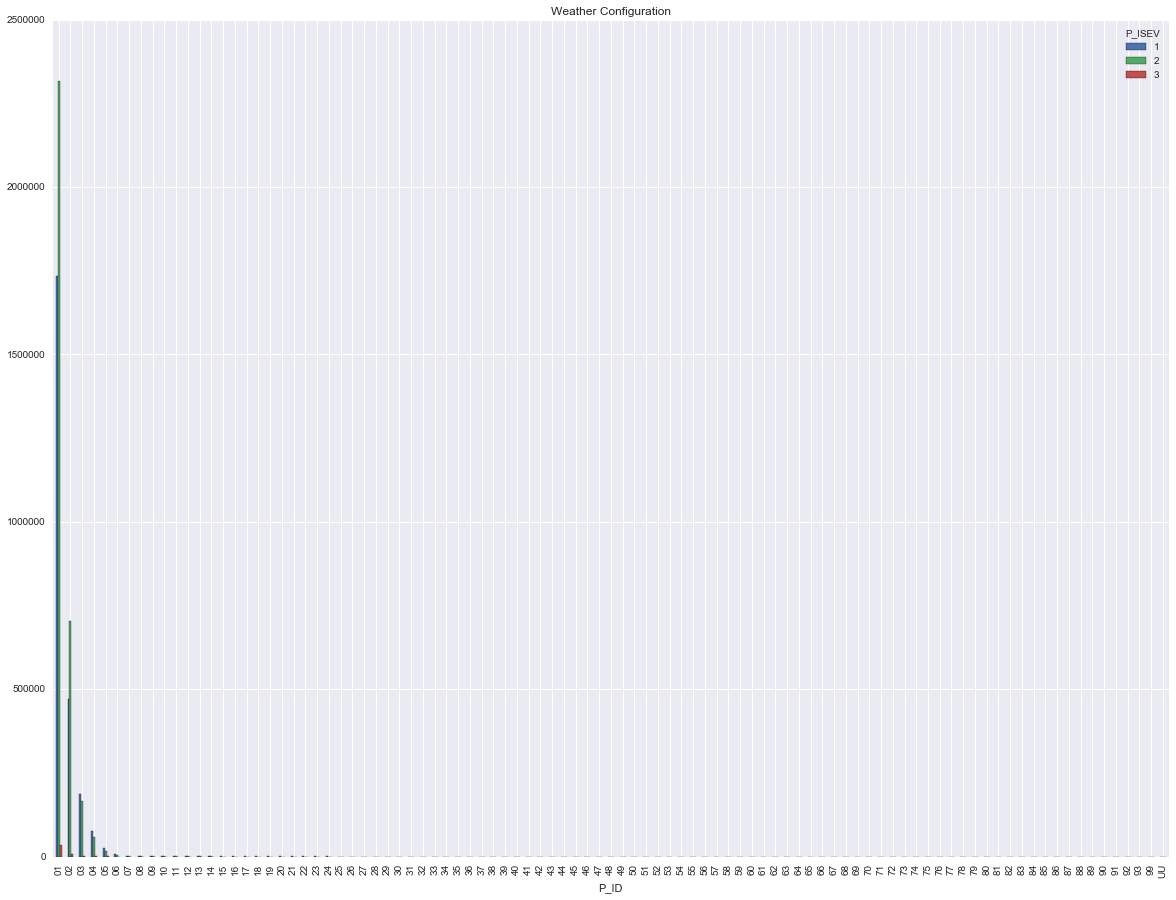

In [56]:
# P_ID - Passenger ID
#df['P_ID'] = df['P_ID'].apply(lambda x: x.replace('NN', '100'))
print("{count} non-numeric rows observed".format(count = df['P_ID'].astype('str').str.contains('[^0-9]').sum()))
gbPID = checkHistogram(df, 'P_ID', 'P_ISEV', True)

P_ISEV          1          2        3
P_ID                                 
01      1733877.0  2317701.0  33613.0
02       469845.0   704557.0   7210.0
03       187960.0   164501.0   2081.0
04        77770.0    57740.0    794.0
05        24495.0    17672.0    308.0
06         7031.0     4864.0     89.0
07         2976.0     1913.0     31.0
08         1397.0      863.0     13.0
09          926.0      502.0      9.0
10          735.0      390.0      5.0
11          599.0      331.0      3.0
12          527.0      264.0      2.0
...           ...        ...      ...
83            1.0        NaN      NaN
84            NaN        1.0      NaN
85            NaN        1.0      NaN
86            1.0        NaN      NaN
87            1.0        NaN      NaN
88            1.0        NaN      NaN
89            1.0        NaN      NaN
90            1.0        NaN      NaN
91            NaN        1.0      NaN
92            1.0        NaN      NaN
93            NaN        1.0      NaN
99          

P_ISEV,1,2,3
P_ID,,,
01,1733879.0,2317707.0,33613.0
02,469848.0,704562.0,7210.0
03,187960.0,164501.0,2081.0
04,77770.0,57743.0,794.0
05,24495.0,17672.0,308.0
06,7031.0,4864.0,89.0
07,2976.0,1913.0,31.0
08,1397.0,863.0,13.0
09,926.0,502.0,9.0


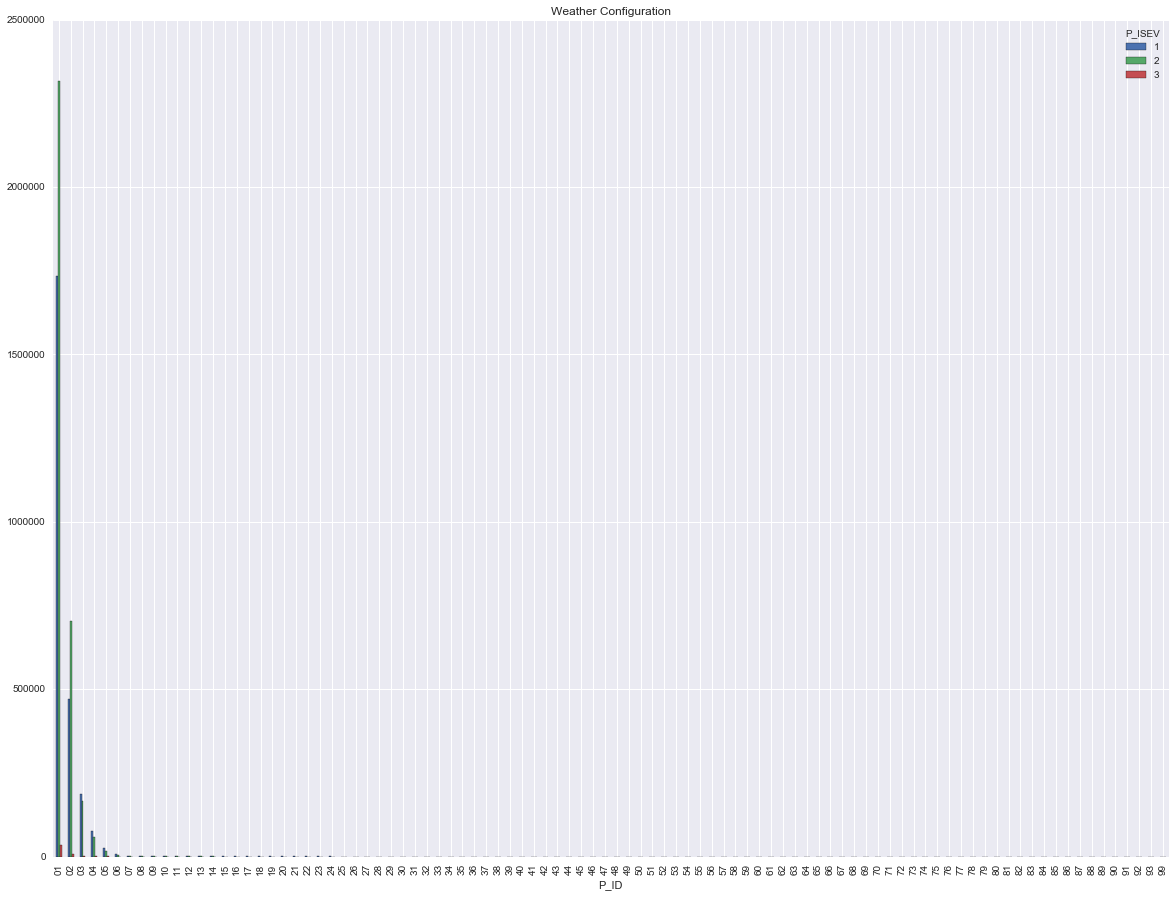

In [57]:
P = computeP(gbPID)

#impute unkown values
df['P_ID'] = df['P_ID'].apply(lambda x: x.replace('UU', selectBin(1, 100, P, True)))
print("{count} non-numeric rows observed".format(count = df['P_ID'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'P_ID', 'P_ISEV', True)

In [58]:
df.columns

Index(['C_YEAR', 'C_MNTH', 'C_WDAY', 'C_HOUR', 'C_VEHS', 'C_CONF', 'C_RCFG',
       'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_ID', 'V_TYPE', 'V_YEAR',
       'P_ID', 'P_SEX', 'P_AGE', 'P_PSN', 'P_SAFE', 'P_USER', 'P_ISEV'],
      dtype='object')

59404 non-numeric rows observed


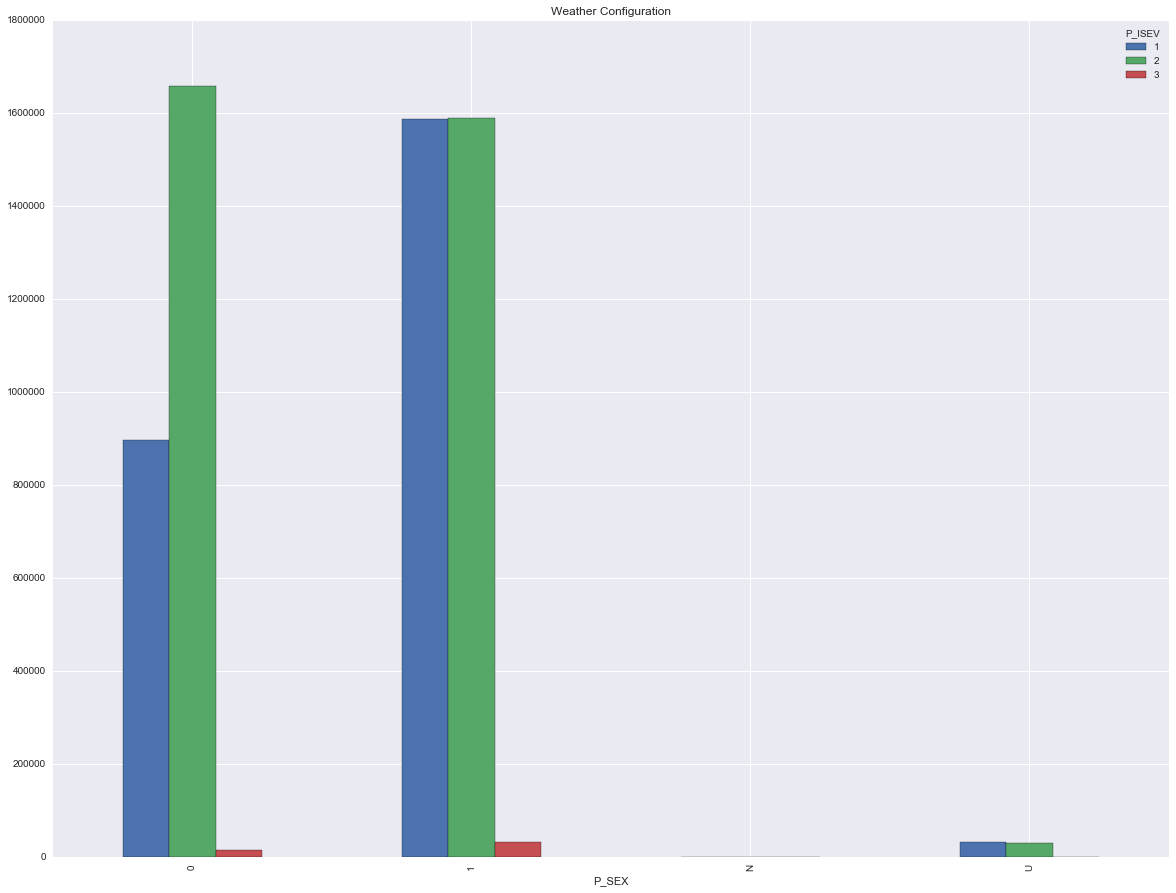

In [59]:
#P_SEX
df['P_SEX'] = df['P_SEX'].apply(lambda x: x.replace('F', '0'))
df['P_SEX'] = df['P_SEX'].apply(lambda x: x.replace('M', '1'))
print("{count} non-numeric rows observed".format(count = df['P_SEX'].astype('str').str.contains('[^0-9]').sum()))
gbPSEX = checkHistogram(df, 'P_SEX', 'P_ISEV', True)

P_ISEV          1          2        3
P_SEX                                
0        895994.0  1656651.0  13563.0
1       1586668.0  1587979.0  30543.0
5771398.0
ind: 0
cur: 1
ind: 1
cur: 2
[0.4446423552837631, 0.5553576447162368]
1.0
0 non-numeric rows observed


P_ISEV,1,2,3
P_SEX,,,
0,895994,1656651,13563
01,13594,12882,22
02,17025,15842,39
1,1586668,1587979,30543


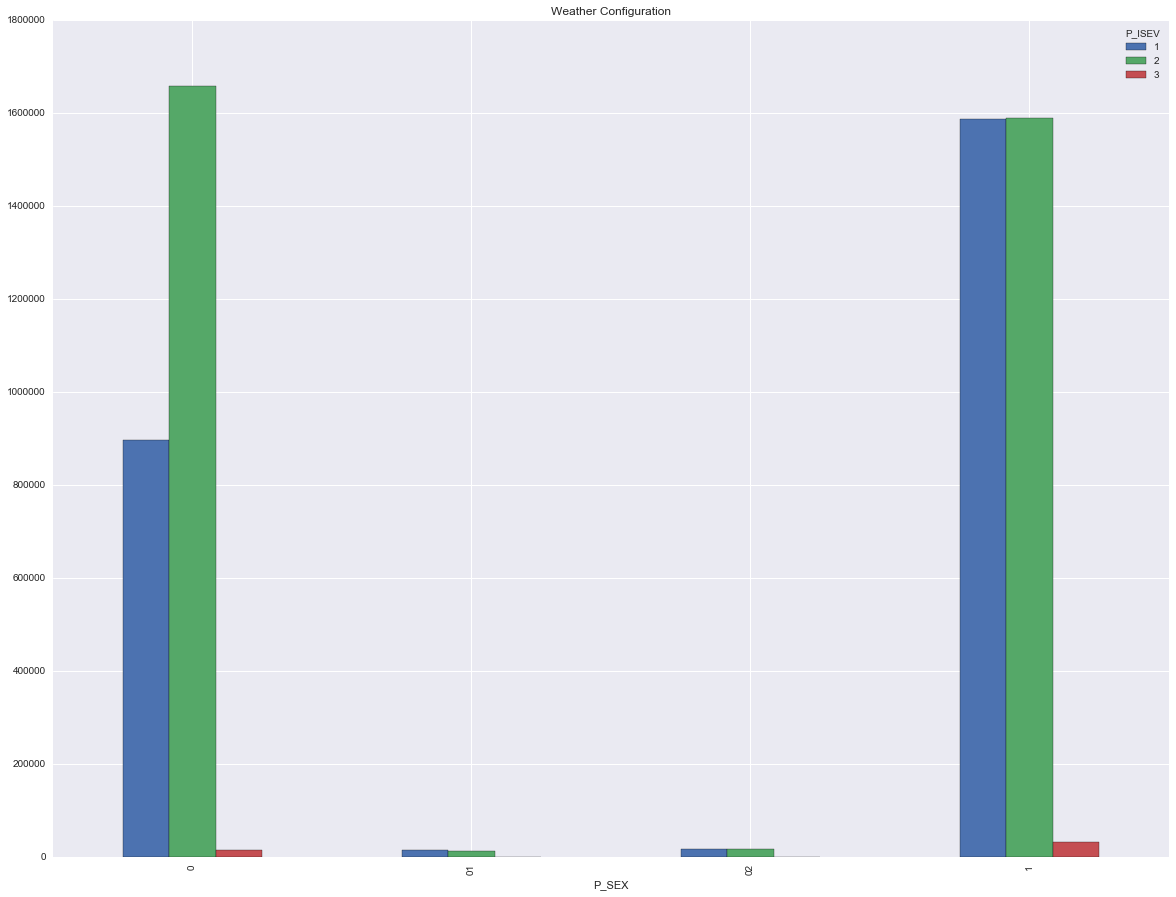

In [60]:
P = computeP(gbPSEX)

#impute unkown values
df['P_SEX'] = df['P_SEX'].apply(lambda x: x.replace('U', selectBin(1, 3, P, False)))
df['P_SEX'] = df['P_SEX'].apply(lambda x: x.replace('N', selectBin(1, 3, P, False)))
print("{count} non-numeric rows observed".format(count = df['P_SEX'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'P_SEX', 'P_ISEV', True)

210054 non-numeric rows observed


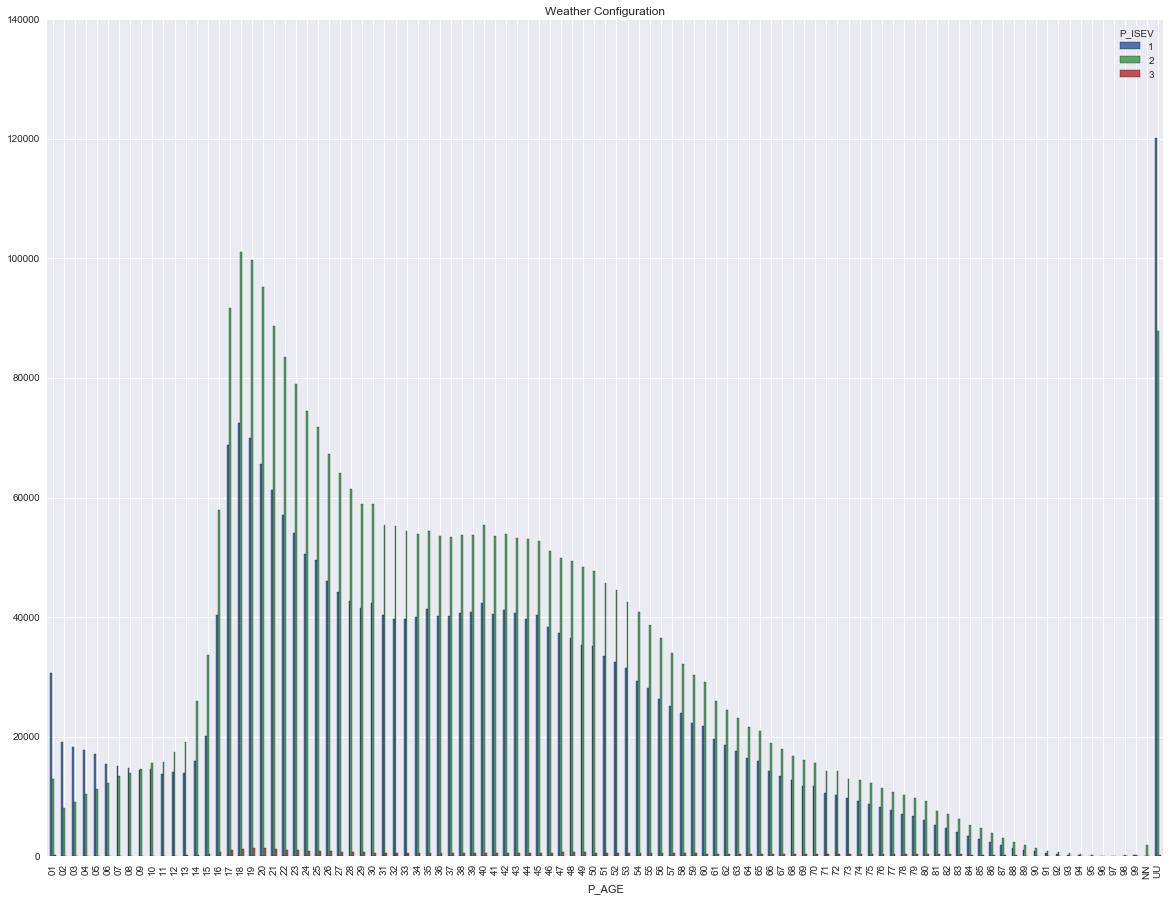

In [61]:
#P_AGE
print("{count} non-numeric rows observed".format(count = df['P_AGE'].astype('str').str.contains('[^0-9]').sum()))
gbPAGE = checkHistogram(df, 'P_AGE', 'P_ISEV', True)

P_ISEV      1      2    3
P_AGE                    
01      30604  12958  158
02      19148   8040   73
03      18351   9059   74
04      17837  10366  100
05      17070  11325  104
06      15402  12267  101
07      15086  13350  106
08      14786  13956   94
09      14369  14552  111
10      14606  15554  113
11      13841  15759  111
12      14149  17411  124
...       ...    ...  ...
88       1374   2428  143
89       1020   1895  120
90        869   1438   84
91        555    922   84
92        403    685   53
93        252    489   40
94        164    338   25
95        113    193   20
96         59    132   13
97         40     90    7
98         72    147    6
99        137    142    8

[99 rows x 3 columns]
5620748
ind: 01
cur: 1
ind: 02
cur: 2
ind: 03
cur: 3
ind: 04
cur: 4
ind: 05
cur: 5
ind: 06
cur: 6
ind: 07
cur: 7
ind: 08
cur: 8
ind: 09
cur: 9
ind: 10
cur: 10
ind: 11
cur: 11
ind: 12
cur: 12
ind: 13
cur: 13
ind: 14
cur: 14
ind: 15
cur: 15
ind: 16
cur: 16
ind: 17
cur: 17
ind:

P_ISEV,1,2,3
P_AGE,,,
01,31517,13669,160
02,19746,8470,73
03,18934,9470,75
04,18427,10816,103
05,17627,11801,107
06,15966,12714,102
07,15700,13809,108
08,15415,14379,95
09,14956,15028,113


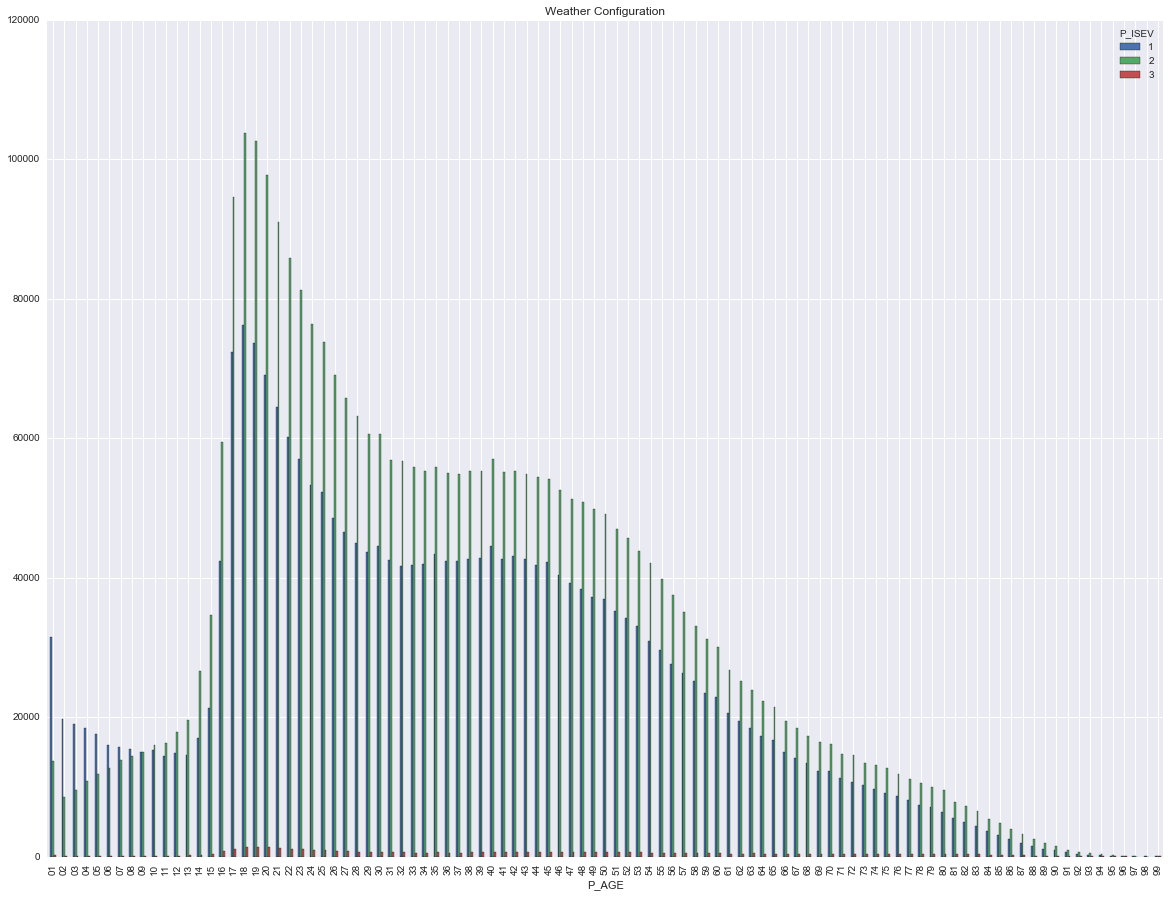

In [62]:
P = computeP(gbPAGE)

#impute unkown values
df['P_AGE'] = df['P_AGE'].apply(lambda x: x.replace('UU', selectBin(1, 100, P, True)))
df['P_AGE'] = df['P_AGE'].apply(lambda x: x.replace('NN', selectBin(1, 100, P, True)))
print("{count} non-numeric rows observed".format(count = df['P_AGE'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'P_AGE', 'P_ISEV', True)

12985 non-numeric rows observed


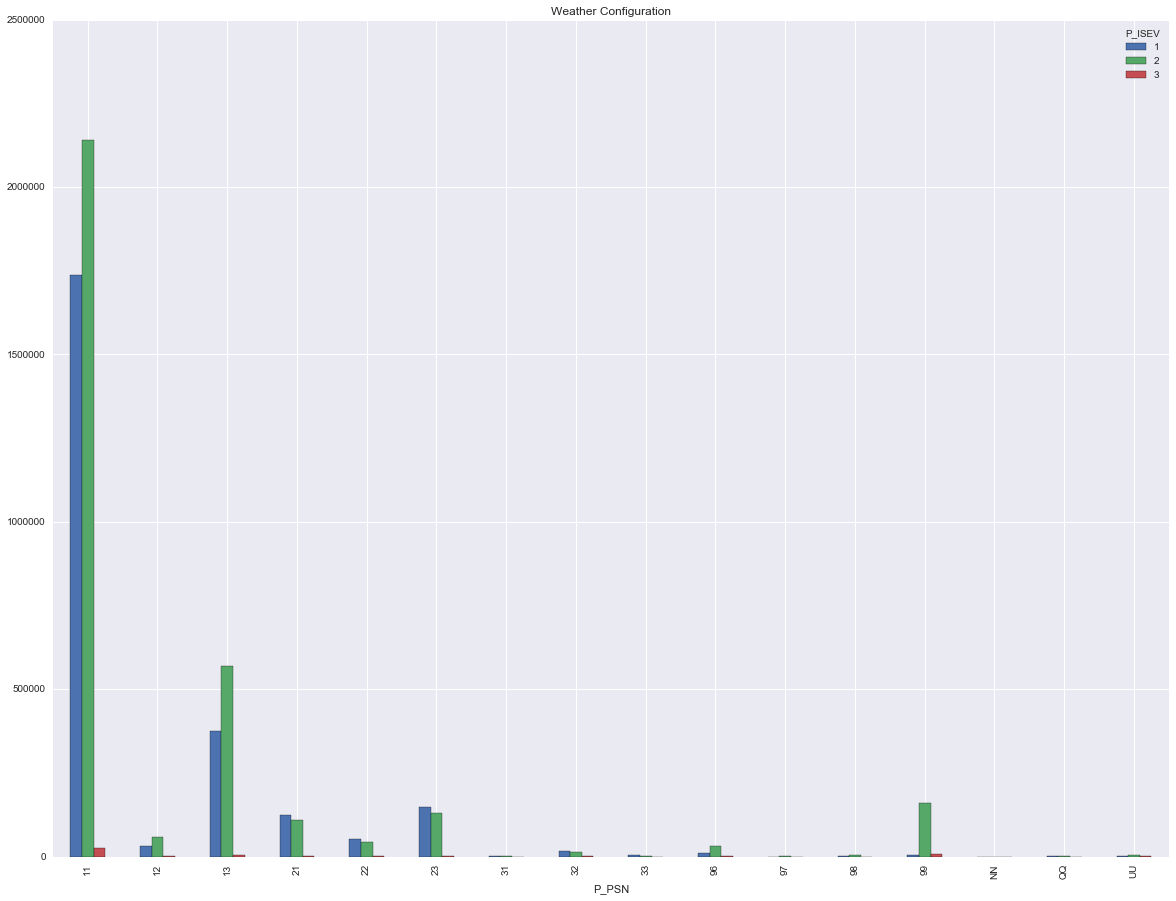

In [63]:
#P_PSN
print("{count} non-numeric rows observed".format(count = df['P_PSN'].astype('str').str.contains('[^0-9]').sum()))
gbPPSN = checkHistogram(df, 'P_PSN', 'P_ISEV', True)

P_ISEV        1        2      3
P_PSN                          
11      1737686  2140914  26745
12        32538    58348    598
13       375851   568015   5862
21       122782   109704   1344
22        51944    43129    501
23       148722   129652   1293
31         2835     2041     35
32        17344    14413    217
33         3444     2744     36
96        10766    31181   1019
97          117      158      4
98         1021     5106    116
99         3644   159781   6167
5817817
ind: 11
cur: 1
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
ind: 12
cur: 12
ind: 13
cur: 13
ind: 21
cur: 14
i: 14
i: 15
i: 16
i: 17
i: 18
i: 19
i: 20
ind: 22
cur: 22
ind: 23
cur: 23
ind: 31
cur: 24
i: 24
i: 25
i: 26
i: 27
i: 28
i: 29
i: 30
ind: 32
cur: 32
ind: 33
cur: 33
ind: 96
cur: 34
i: 34
i: 35
i: 36
i: 37
i: 38
i: 39
i: 40
i: 41
i: 42
i: 43
i: 44
i: 45
i: 46
i: 47
i: 48
i: 49
i: 50
i: 51
i: 52
i: 53
i: 54
i: 55
i: 56
i: 57
i: 58
i: 59
i: 60
i: 61
i: 62
i: 63
i: 64
i: 65
i: 66
i: 67
i: 68
i: 69
i:

P_ISEV,1,2,3
P_PSN,,,
11,1740743,2146453,26899
12,32610,58473,602
13,376599,569312,5899
21,122955,110036,1352
22,52025,43273,505
23,148959,130013,1308
31,2839,2047,35
32,17370,14450,218
33,3447,2749,36


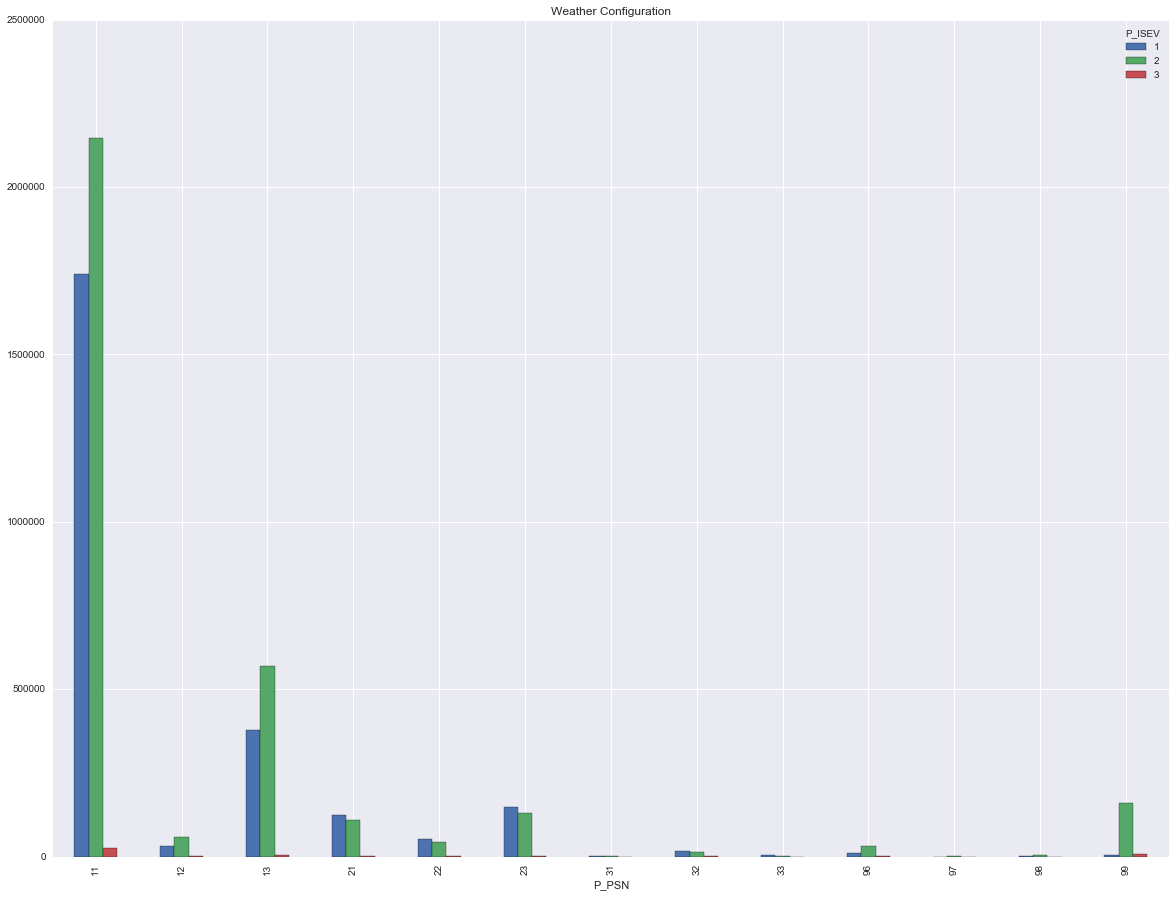

In [64]:
P = computeP(gbPPSN)

#impute unkown values
df['P_PSN'] = df['P_PSN'].apply(lambda x: x.replace('UU', selectBin(1, 100, P, True)))
df['P_PSN'] = df['P_PSN'].apply(lambda x: x.replace('NN', selectBin(1, 100, P, True)))
df['P_PSN'] = df['P_PSN'].apply(lambda x: x.replace('QQ', selectBin(1, 100, P, True)))
print("{count} non-numeric rows observed".format(count = df['P_PSN'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'P_PSN', 'P_ISEV', True)

797464 non-numeric rows observed


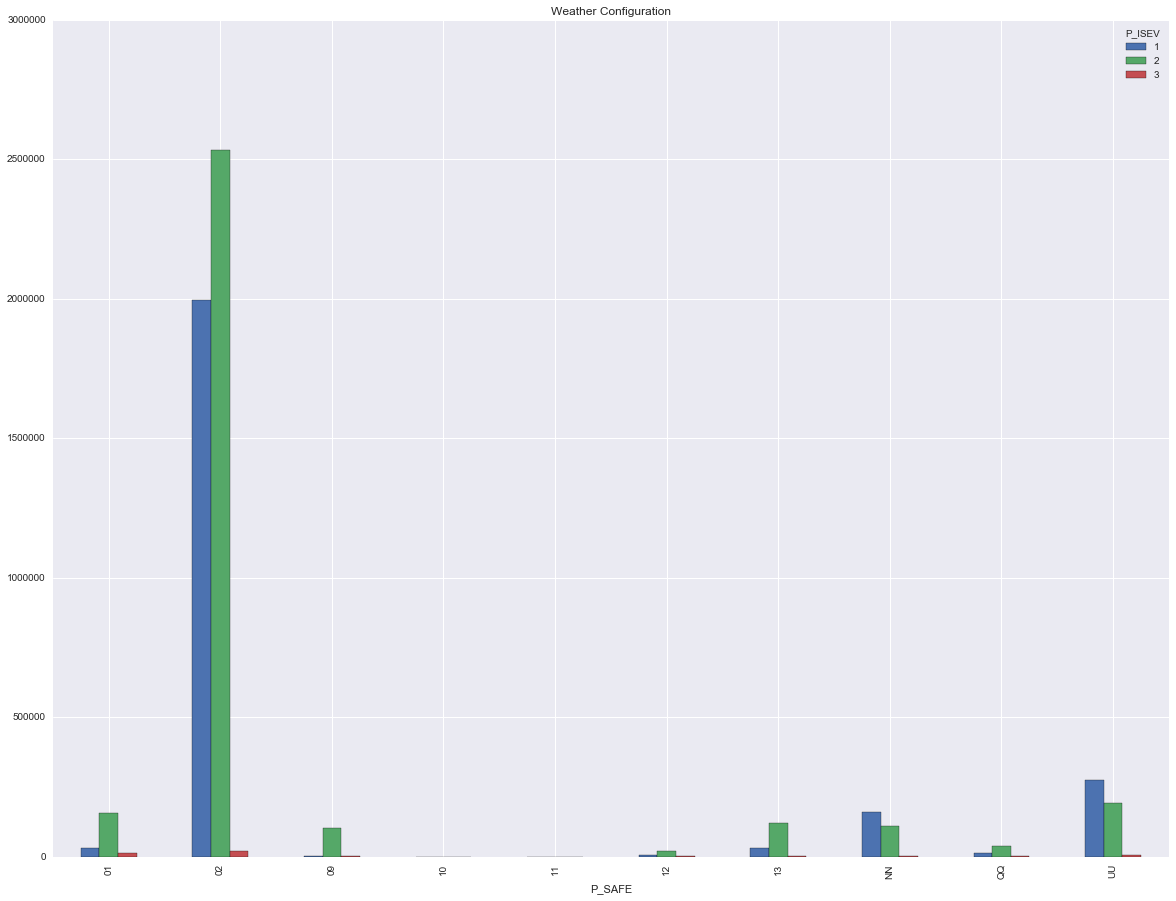

In [65]:
#P_SAFE
print("{count} non-numeric rows observed".format(count = df['P_SAFE'].astype('str').str.contains('[^0-9]').sum()))
gbPSAFE = checkHistogram(df, 'P_SAFE', 'P_ISEV', True)

P_ISEV        1        2      3
P_SAFE                         
01        31800   155793  11106
02      1994042  2532572  18127
09         3562   103869   2955
10            8      131     13
11            3        9      1
12         4977    20578    348
13        31894   119235   2315
5033338
ind: 01
cur: 1
ind: 02
cur: 2
ind: 09
cur: 3
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
ind: 10
cur: 10
ind: 11
cur: 11
ind: 12
cur: 12
ind: 13
cur: 13
[0.03947658591574816, 0.9029278383450505, 0, 0, 0, 0, 0, 0, 0.021930973044130952, 3.019864749794272e-05, 2.5827790623240483e-06, 0.005146286619336909, 0.03048553464917317]
1.0
0 non-numeric rows observed


P_ISEV,1,2,3
P_SAFE,,,
01,49576,169228,11469
02,2397596,2840562,26532
09,13346,111376,3161
10,21,144,13
11,3,9,1
12,7223,22255,397
13,45516,129780,2594


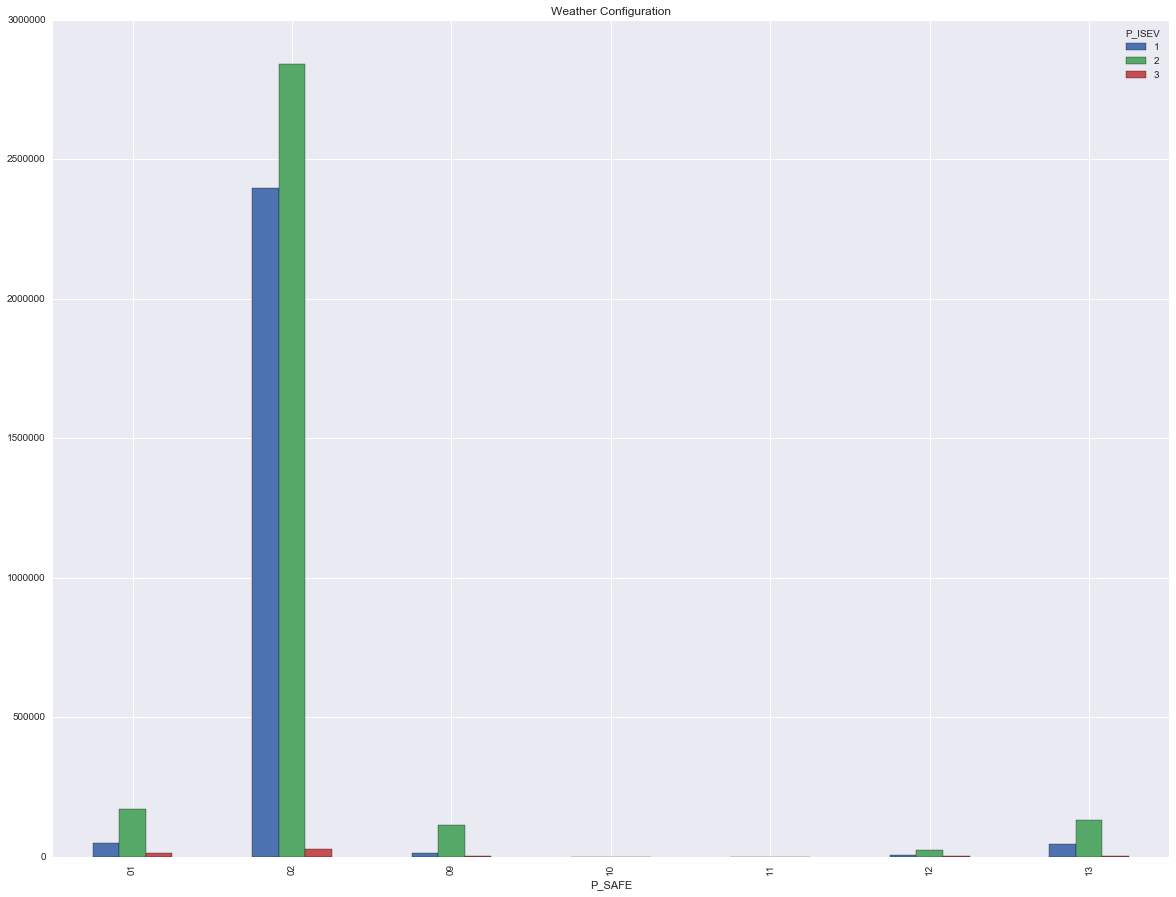

In [66]:
P = computeP(gbPSAFE)

#impute unkown values
df['P_SAFE'] = df['P_SAFE'].apply(lambda x: x.replace('UU', selectBin(1, 14, P, True)))
df['P_SAFE'] = df['P_SAFE'].apply(lambda x: x.replace('NN', selectBin(1, 14, P, True)))
df['P_SAFE'] = df['P_SAFE'].apply(lambda x: x.replace('QQ', selectBin(1, 14, P, True)))
print("{count} non-numeric rows observed".format(count = df['P_SAFE'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'P_SAFE', 'P_ISEV', True)

64409 non-numeric rows observed


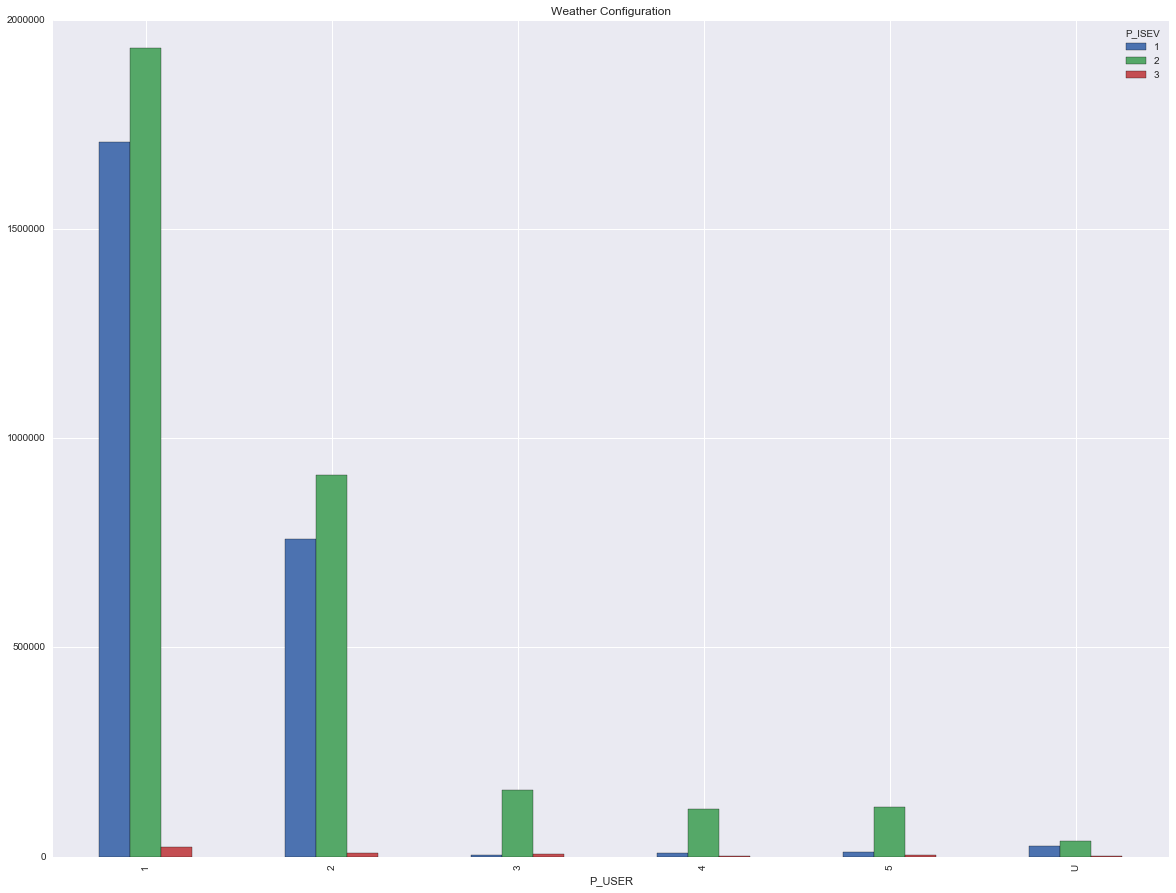

In [67]:
#P_USER
print("{count} non-numeric rows observed".format(count = df['P_USER'].astype('str').str.contains('[^0-9]').sum()))
gbPUSER = checkHistogram(df, 'P_USER', 'P_ISEV', True)

P_ISEV        1        2      3
P_USER                         
1       1707581  1931514  22322
2        758594   911170   9787
3          3684   159792   6167
4          7927   114159   1003
5         10891   118315   3487
5766393
ind: 1
cur: 1
ind: 2
cur: 2
ind: 3
cur: 3
ind: 4
cur: 4
ind: 5
cur: 5
[0.6349579364431109, 0.2912654409784418, 0.02941925741100199, 0.021345926300895553, 0.023011438866549678]
1.0
0 non-numeric rows observed


P_ISEV,1,2,3
P_USER,,,
01,15744,24380,857
02,7079,11244,429
03,672,1117,48
04,525,775,27
05,584,888,40
1,1707581,1931514,22322
2,758594,911170,9787
3,3684,159792,6167
4,7927,114159,1003


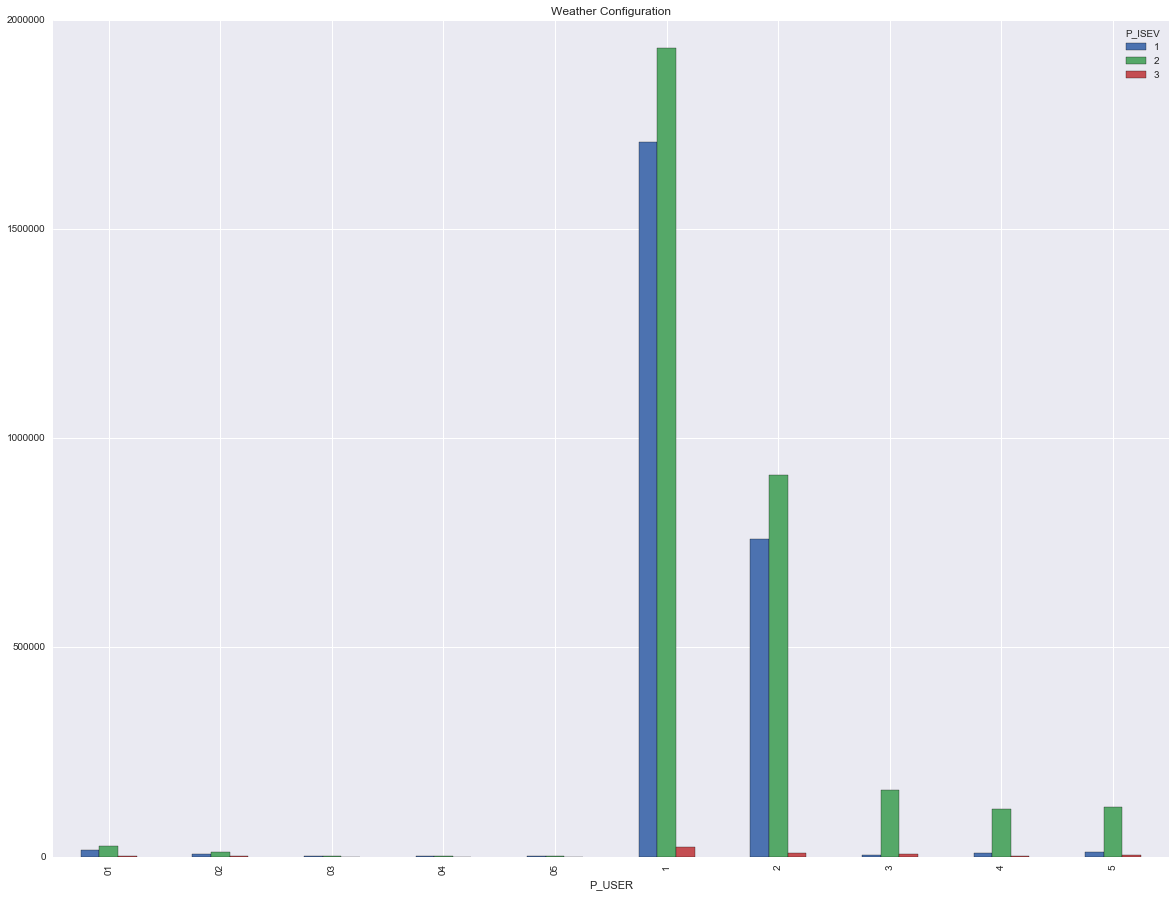

In [68]:
P = computeP(gbPUSER)

#impute unkown values
df['P_USER'] = df['P_USER'].apply(lambda x: x.replace('U', selectBin(1, 6, P, False)))
print("{count} non-numeric rows observed".format(count = df['P_USER'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'P_USER', 'P_ISEV', True)

In [69]:
#P_ISEV
print("{count} non-numeric rows observed".format(count = df['P_ISEV'].astype('str').str.contains('[^0-9]').sum()))
#gbPUSER = checkHistogram(df, 'P_ISEV', 'P_ISEV', True)

0 non-numeric rows observed


In [70]:
df['P_ISEV'] = df['P_ISEV'].apply(lambda x: x.replace('1', '0'))
df['P_ISEV'] = df['P_ISEV'].apply(lambda x: x.replace('2', '1'))
df['P_ISEV'] = df['P_ISEV'].apply(lambda x: x.replace('3', '2'))

In [76]:
#Year vs Severity
#Year vs Severity
#df.groupby(['P_ISEV', 'P_ISEV']).size().unstack().plot(figsize=(8,10), kind='bar', title = 'P_ISEV vs Accident Severity', stacked = True)
print("{count} non-numeric rows observed".format(count = df['P_ISEV'].astype('str').str.contains('[^0-9]').sum()))

0 non-numeric rows observed


In [77]:
#drop rows which has more than four columns with missing values
#df.drop(df.index[df.isin(['U', 'UU', 'UUU', 'UUUU']).sum(axis=1) >= 1], inplace=True)
#df.drop(df.index[df.isin(['N', 'NN', 'NNN', 'NNNN']).sum(axis=1) >= 1], inplace=True)
#df.drop(df.index[df.isin(['Q', 'QQ', 'QQQ', 'QQQQ']).sum(axis=1) >= 1], inplace=True)
#df.drop(df.index[df.isin(['X', 'XX', 'XXX', 'XXXX']).sum(axis=1) >= 1], inplace=True)
#df = df.reset_index(drop=True)
#print(df.shape)

In [78]:
print("This dataset has {0} missing value".format(df.isnull().sum().sum()))
print("This dataset has {0} NA value".format(df.isna().sum().sum()))

This dataset has 0 missing value
This dataset has 0 NA value


In [79]:
df.to_csv('data01_clean.csv', encoding='utf-8', index=False)

In [80]:
df.shape

(5830802, 21)

In [81]:
#set the correct type for each variable
df = df.astype('category')
#df['C_YEAR'] = df['C_YEAR'].astype('int64')
df['C_VEHS'] = df['C_VEHS'].astype('int64')
#df['V_YEAR'] = df['V_YEAR'].astype('int64')
df['P_AGE'] = df['P_AGE'].astype('int64')

ValueError: invalid literal for int() with base 10: 'UU'

In [ ]:
#df of categorical and numberic varaibales
df_cat = df.select_dtypes(include=['category']).copy()
df_int = df.select_dtypes(include=['int64']).copy()

In [ ]:
print(df_cat.head())
print(df_int.head())

In [ ]:
pd.options.display.float_format = '{:.4g}'.format
df_int.describe()

In [ ]:
df_int[['C_VEHS']].boxplot()

In [ ]:
df_int[['P_AGE']].boxplot()

In [ ]:
df_b = df.copy()
df_b['fatal']=np.where(df_b['P_ISEV'] == '3',1,0)
df_b['injury']=np.where(df_b['P_ISEV'] == '2',1,0)
df_b['no_injury']=np.where(df_b['P_ISEV'] == '1',1,0)

df1 = df_b.groupby('C_YEAR')['fatal','injury', 'no_injury'].sum()
df1

In [ ]:
#The overall diagram
plot1 = df1.plot(figsize=(10,10),title='Collision overall statistics')
plot1.set_xlabel("Year")
plot1.set_ylabel("Number of collisions");

In [ ]:
#Collisions by weekday
by_weekday = df_b.groupby('C_WDAY')['P_ISEV'].count()
by_weekday.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plot2 = by_weekday.plot(kind='bar',title='Collisions by day');

In [ ]:
#Collisions by hour
plt.figure(figsize=(15,5))
by_hour = df_b.groupby('C_HOUR')['P_ISEV'].count()
plot3 = by_hour.plot(kind='bar',title='Collisions by hour',color='B');

In [ ]:
#Year vs Severity
df.groupby(['C_YEAR', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'Year vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_MNTH', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'Month vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_WDAY', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'Day vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_HOUR', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'HOUR vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_VEHS', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'C_VEHS vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_CONF', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_CONF vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_RCFG', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_RCFG vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_WTHR', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_WTHR vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_RSUR', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_WTHR vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_RALN', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_RALN vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_TRAF', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_TRAF vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['V_ID', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'V_ID vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['V_TYPE', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'V_TYPE vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['V_YEAR', 'P_ISEV']).size().unstack().plot(figsize=(25,20), kind='bar', title = 'V_YEAR vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['P_ID', 'P_ISEV']).size().unstack().plot(figsize=(25,20), kind='bar', title = 'P_ID vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['P_SEX', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'P_SEX vs Accident Severity', stacked = True)

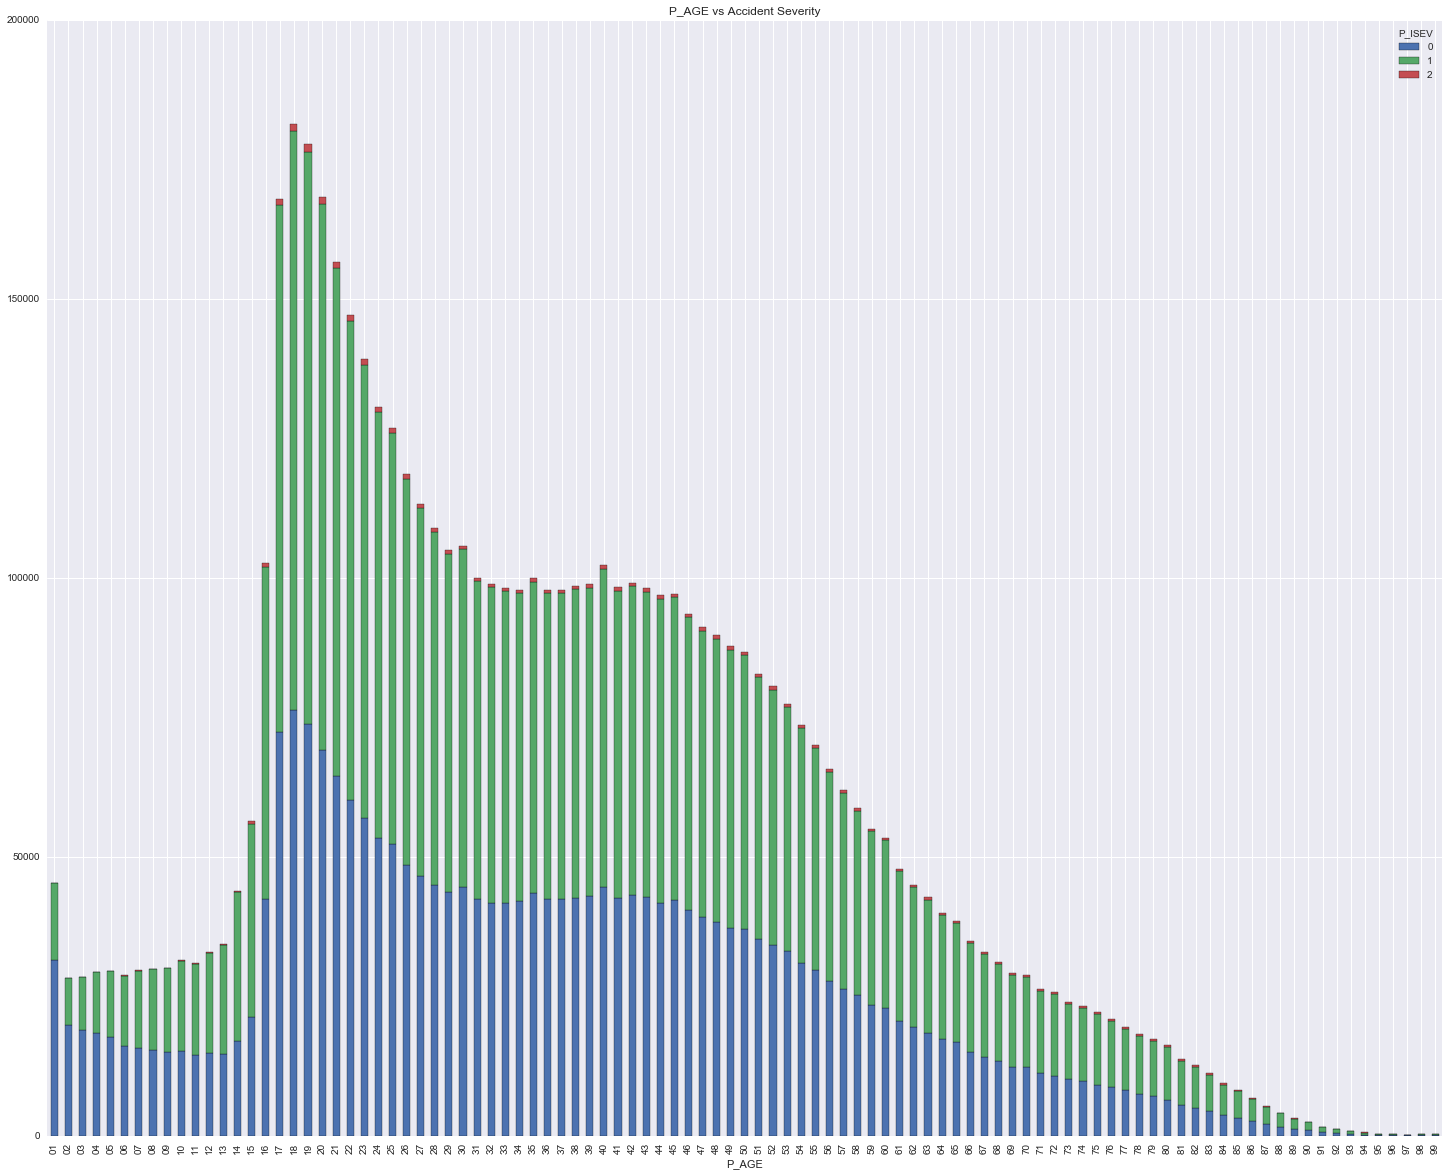

In [82]:
#Year vs Severity
df.groupby(['P_AGE', 'P_ISEV']).size().unstack().plot(figsize=(25,20), kind='bar', title = 'P_AGE vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['P_PSN', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'P_PSN vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['P_SAFE', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'P_SAFE vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['P_USER', 'P_ISEV']).size().unstack().plot(figsize=(10,15), kind='bar', title = 'P_USER vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['P_ISEV', 'P_ISEV']).size().unstack().plot(figsize=(8,10), kind='bar', title = 'P_ISEV vs Accident Severity', stacked = True)

In [ ]:
%matplotlib inline
df_int[['C_VEHS', 'P_AGE']].boxplot()

In [ ]:
#check if dataset contains nulls
if df.isnull().sum().sum():
    print("Dataset contains Null values")
else:
    print("No Null values in the Dataset")

In [ ]:
if df.isna().sum().sum():
    print("Dataset contains missing values")
else:
    print("No missing values in the Dataset")

### inspect the data types as imported